In [98]:
from datasets import load_dataset
import json
import torch
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer
from tqdm import tqdm
from vllm import LLM, SamplingParams
import os
from dotenv import load_dotenv
from typing import List, Dict, Tuple, Optional, Union
import seaborn as sns

load_dotenv()


False

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model = model.to(device) 

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/680 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-000002.safetensors:   0%|          | 0.00/6.62G [00:00<?, ?B/s]

model-00001-of-000002.safetensors:   0%|          | 0.00/8.61G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

In [4]:
new_system_prompt = "Please solve the problem step by step (separate steps with double newlines), but keep it short and put your final answer (do not include any other text or units) within \\boxed{}."

In [5]:
def infer(input, temperature=0.7, max_new_tokens=256, top_p=0.9, top_k=50, do_sample=True, system_prompt=None):
    if isinstance(input, str):
        if system_prompt is None:
            messages = [{"role": "user", "content": input}]
        else:
            messages = [{"role": "system", "content": system_prompt}, {"role": "user", "content": input}]
    elif isinstance(input, list):
        messages = input
    else:
        raise ValueError("input phải là string hoặc list of dict")
    
    inputs = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt",
    ).to(device)
    
    outputs = model.generate(   
        **inputs,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        do_sample=do_sample,
    )
    
    len_inputs = inputs['input_ids'].shape[-1]
    response = tokenizer.decode(outputs[0][len_inputs:], skip_special_tokens=True)
    
    return response

def infer_batch(messages_list, temperature=0.7, max_new_tokens=256, top_p=0.9, top_k=50, do_sample=True):
    all_messages = []
    for item in messages_list:
        if isinstance(item, str):
            all_messages.append([{"role": "user", "content": item}])
        elif isinstance(item, list):
            all_messages.append(item)
        else:
            raise ValueError("Mỗi phần tử phải là string hoặc list of dict")
    
    inputs = tokenizer.apply_chat_template(
        all_messages,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt",
        padding=True,
    ).to(device)
    
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        do_sample=do_sample,
    )
    
    responses = []
    for i in range(len(outputs)):
        input_ids = inputs['input_ids'][i]
        non_pad_length = (input_ids != tokenizer.pad_token_id).sum().item()
        
        response = tokenizer.decode(
            outputs[i][non_pad_length:], 
            skip_special_tokens=True
        )
        responses.append(response)
    
    return responses

In [ ]:
sample_question = """
Every morning Aya goes for a $9$-kilometer-long walk and stops at a coffee shop afterwards. When she walks at a constant speed of $s$ kilometers per hour, the walk takes her 4 hours, including $t$ minutes spent in the coffee shop. When she walks $s+2$ kilometers per hour, the walk takes her 2 hours and 24 minutes, including $t$ minutes spent in the coffee shop. Suppose Aya walks at $s+\frac{1}{2}$ kilometers per hour. Find the number of minutes the walk takes her, including the $t$ minutes spent in the coffee shop.
"""

In [8]:
sample_question2 = """
Eliza's rate per hour for the first 40 hours she works each week is $10. She also receives an overtime pay of 1.2 times her regular hourly rate. If Eliza worked for 45 hours this week, how much are her earnings for this week?
"""

In [7]:
print(infer(sample_question, 
                system_prompt=None,
                max_new_tokens=4096,
                temperature=0.0,
                do_sample=False
            )
)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Okay, so I have this problem where Aya goes for a 9-kilometer walk every morning and then stops at a coffee shop. The problem gives me two different scenarios about her walking speed and the time it takes, including the time she spends in the coffee shop. I need to find out how long it takes her when she walks at a speed of s + 1/2 kilometers per hour, including the coffee shop time.

Let me try to break this down step by step.

First, let's parse the information given:

1. When Aya walks at a constant speed of s km/h, the entire trip (walk + coffee shop) takes 4 hours.
2. When she walks at s + 2 km/h, the entire trip takes 2 hours and 24 minutes.
3. In both cases, the time spent in the coffee shop is t minutes.
4. We need to find the total time when she walks at s + 1/2 km/h, including the coffee shop time.

So, the key here is that the coffee shop time, t, is the same in both scenarios. The difference is in her walking speed and the total time taken.

Let me denote the time she spend

In [9]:
print(infer(sample_question2, 
                system_prompt=None,
                max_new_tokens=4096,
                temperature=0.0,
                do_sample=False
            )
)

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


First, I need to calculate Eliza's regular pay for the first 40 hours. Since her regular hourly rate is $10, multiplying 40 hours by $10 gives $400.

Next, I'll determine her overtime pay for the additional 5 hours she worked beyond the 40-hour limit. The overtime rate is 1.2 times her regular rate, which is 1.2 multiplied by $10, resulting in $12 per hour.

Finally, I'll calculate the total earnings by adding her regular pay and overtime pay: $400 plus (5 hours multiplied by $12) equals $460.
</think>

**Solution:**

Eliza's earnings can be calculated by considering both her regular pay and her overtime pay.

1. **Regular Pay:**
   - **Regular Hours:** 40 hours
   - **Regular Hourly Rate:** \$10
   - **Calculation:** 
     \[
     \text{Regular Pay} = 40 \text{ hours} \times \$10/\text{hour} = \$400
     \]

2. **Overtime Pay:**
   - **Overtime Hours:** 45 hours total worked - 40 regular hours = 5 overtime hours
   - **Overtime Hourly Rate:** 1.2 times the regular rate = \(1.2 \times 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional, Union
import seaborn as sns


def calculate_token_entropy_transformers(
    scores: torch.Tensor,
    tokenizer,
    output_tokens: List[str],
    top_k_display: int = 5
) -> List[Dict]:
    """
    Tính EXACT entropy over full vocab từ transformers scores (GPU-optimized)
    
    NOTE: Hàm này tính exact entropy, KHÔNG approximate như vLLM version
    
    Args:
        scores: Stacked scores từ outputs.scores, shape (T, B, V)
        tokenizer: Tokenizer để decode tokens
        output_tokens: List of decoded output tokens
        top_k_display: Số lượng top alternatives để hiển thị (default 5)
        
    Returns:
        List of dicts chứa entropy info cho mỗi token
    """
    # ===== 1) Prepare logits =====
    if scores.dim() == 3:
        logits = scores[:, 0, :]  # (T, V) - assume batch=1
    else:
        logits = scores  # Already (T, V)
    
    T, V = logits.shape
    
    # ===== 2) Exact entropy over full vocab (GPU vectorized) =====
    # H = logZ - sum(p * logits)
    # Using the formula: H = -sum(p * log(p)) = -sum(p * (log(p_i) - log(Z)))
    #                      = log(Z) - sum(p * log(p_i))
    logZ = torch.logsumexp(logits, dim=-1)  # (T,)
    probs = torch.softmax(logits, dim=-1)   # (T, V)
    entropy = logZ - (probs * logits).sum(dim=-1)  # (T,)
    
    # ===== 3) Top-k alternatives for display (GPU) =====
    topk_logits, topk_indices = torch.topk(logits, k=top_k_display, dim=-1)  # (T, k)
    
    # logprob of topk according to full vocab softmax:
    # log p(token_i) = logit_i - logZ
    topk_logprobs = topk_logits - logZ.unsqueeze(-1)  # (T, k)
    
    # topk probs for display
    topk_probs = torch.exp(topk_logprobs)  # (T, k)
    
    # ===== 4) Move only small tensors to CPU for python dict =====
    entropy_cpu = entropy.detach().cpu().tolist()
    topk_indices_cpu = topk_indices.detach().cpu().tolist()
    topk_logprobs_cpu = topk_logprobs.detach().cpu().tolist()
    topk_probs_cpu = topk_probs.detach().cpu().tolist()
    
    # ===== 5) Build entropies list (loop only for decoding tokens & packaging) =====
    entropies = []
    
    for pos in range(T):
        topk_tokens = [tokenizer.decode([idx]) for idx in topk_indices_cpu[pos]]
        
        entropies.append({
            "position": pos,
            "token": output_tokens[pos] if pos < len(output_tokens) else "",
            "entropy": entropy_cpu[pos],
            "top_alternatives": list(zip(topk_tokens, topk_logprobs_cpu[pos])),  # (token, logprob)
            "top_probs": topk_probs_cpu[pos],  # only top-k probs for display
            "num_tokens_used": V,  # exact over full vocab
            "prob_coverage": 1.0   # exact coverage
        })
    
    return entropies


[2026-01-11 11:17:09] INFO font_manager.py:1639: generated new fontManager


In [95]:
## 📊 ICR Probe: Update Direction of Hidden States
# Based on paper: "ICR Probe: Tracking Hidden State Dynamics for Reliable Hallucination Detection in LLMs"
# Reference: Section 3 - ICR Score

import torch
import torch.nn.functional as F
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy as scipy_entropy


def compute_update_direction(
    hidden_states: torch.Tensor,
    layer_idx: int,
    token_idx: Optional[int] = None,
    normalize_method: str = 'softmax'  # 'softmax', 'l1_norm', 'abs_softmax'
) -> Dict:
    """
    Compute the Update Direction of Hidden States at a specific layer.
    
    Based on ICR Probe paper Section 3.1: Residual Stream Update Process
    
    Formula:
        Δh_i^ℓ = h_i^ℓ - h_i^(ℓ-1)  (residual update from layer ℓ-1 to ℓ)
        Proj_i^ℓ = Normalize(|Δh_i^ℓ|)  (project to simplex)
    
    Args:
        hidden_states: Tuple of hidden states from model forward pass
                      Shape: tuple of (batch_size, seq_len, hidden_dim)
                      hidden_states[0] = embedding layer
                      hidden_states[1] = after layer 0
                      hidden_states[ℓ+1] = after layer ℓ
        layer_idx: Layer index to compute update (0-indexed)
                  layer_idx=0 means update from embedding to layer 0
                  layer_idx=ℓ means update from layer ℓ-1 to layer ℓ
        token_idx: Optional token index to compute for specific token
                  If None, compute for all tokens
        normalize_method: Method to project to simplex
                         - 'softmax': softmax(|Δh|)
                         - 'l1_norm': |Δh| / sum(|Δh|)
                         - 'abs_softmax': softmax on absolute values (paper's method)
    
    Returns:
        Dictionary containing:
            - 'delta_hidden': Raw update vector Δh (shape: [seq_len, hidden_dim] or [hidden_dim])
            - 'proj_simplex': Projected to simplex (probability distribution)
            - 'update_norm': L2 norm of update vector
            - 'layer_idx': Layer index used
            - 'token_idx': Token index (or None if all tokens)
    """
    # Validate layer_idx
    num_layers = len(hidden_states) - 1  # -1 because first is embedding
    if layer_idx < 0 or layer_idx >= num_layers:
        raise ValueError(f"layer_idx must be in [0, {num_layers-1}], got {layer_idx}")
    
    # Get hidden states at layer ℓ-1 and ℓ
    # hidden_states[0] = embedding, hidden_states[ℓ+1] = after layer ℓ
    h_prev = hidden_states[layer_idx]      # h^(ℓ-1) or embedding if layer_idx=0
    h_curr = hidden_states[layer_idx + 1]  # h^ℓ
    
    # Compute update: Δh = h^ℓ - h^(ℓ-1)
    delta_h = h_curr - h_prev  # Shape: (batch, seq_len, hidden_dim)
    
    # Extract for specific token if specified
    if token_idx is not None:
        delta_h_token = delta_h[0, token_idx, :]  # Shape: (hidden_dim,)
        use_delta = delta_h_token
    else:
        delta_h_token = delta_h[0]  # Shape: (seq_len, hidden_dim)
        use_delta = delta_h_token
    
    # Compute update norm (L2)
    if token_idx is not None:
        update_norm = torch.norm(use_delta, p=2).item()
    else:
        update_norm = torch.norm(use_delta, p=2, dim=-1).cpu().numpy()
    
    # Project to simplex (convert to probability distribution)
    # Paper uses: Proj_i^ℓ = normalize(|Δh_i^ℓ|)
    abs_delta = torch.abs(use_delta)
    
    if normalize_method == 'softmax':
        # Softmax normalization
        proj_simplex = F.softmax(abs_delta, dim=-1)
    elif normalize_method == 'l1_norm':
        # L1 normalization: |Δh| / sum(|Δh|)
        proj_simplex = abs_delta / (abs_delta.sum(dim=-1, keepdim=True) + 1e-10)
    elif normalize_method == 'abs_softmax':
        # Paper's method: softmax on absolute values
        # More numerically stable for large hidden dims
        proj_simplex = F.softmax(abs_delta, dim=-1)
    else:
        raise ValueError(f"Unknown normalize_method: {normalize_method}")
    
    # Move to CPU for return
    delta_h_cpu = use_delta.detach().cpu()
    proj_simplex_cpu = proj_simplex.detach().cpu()
    
    return {
        'delta_hidden': delta_h_cpu,
        'proj_simplex': proj_simplex_cpu,
        'update_norm': update_norm,
        'layer_idx': layer_idx,
        'token_idx': token_idx,
        'normalize_method': normalize_method
    }


def compute_icr_score(
    hidden_states: torch.Tensor,
    attention_weights: torch.Tensor,
    layer_idx: int,
    token_idx: int,
    head_aggregation: str = 'mean'  # 'mean', 'max', 'specific'
) -> Dict:
    """
    Compute ICR Score (Information Contribution to Residual Stream).
    
    Based on ICR Probe paper Section 3.2: ICR Score
    
    Formula:
        ICR_i^ℓ = JSD(Proj_i^ℓ, Attn_i^ℓ)
    
    where:
        - Proj_i^ℓ: Update direction projected to simplex (from hidden states)
        - Attn_i^ℓ: Attention distribution at token i, layer ℓ
        - JSD: Jensen-Shannon Divergence
    
    Args:
        hidden_states: Tuple of hidden states
        attention_weights: Tuple of attention tensors
                          Shape: (batch, num_heads, seq_len, seq_len)
        layer_idx: Layer index (0-indexed)
        token_idx: Token index to compute ICR for
        head_aggregation: How to aggregate attention across heads
                         - 'mean': average across all heads
                         - 'max': max attention across heads
                         - 'specific': use specific head (not implemented)
    
    Returns:
        Dictionary containing:
            - 'icr_score': ICR score (JSD between Proj and Attn)
            - 'proj_simplex': Update direction distribution
            - 'attn_dist': Attention distribution
            - 'update_entropy': Entropy of update direction
            - 'attn_entropy': Entropy of attention distribution
    """
    # 1. Compute update direction (Proj_i^ℓ)
    update_result = compute_update_direction(
        hidden_states=hidden_states,
        layer_idx=layer_idx,
        token_idx=token_idx,
        normalize_method='abs_softmax'
    )
    proj_simplex = update_result['proj_simplex'].numpy()
    
    # 2. Get attention distribution (Attn_i^ℓ)
    # attention_weights[layer_idx] shape: (batch, num_heads, seq_len, seq_len)
    attn = attention_weights[layer_idx][0, :, token_idx, :]  # (num_heads, seq_len)
    
    # Aggregate across heads
    if head_aggregation == 'mean':
        attn_dist = attn.mean(dim=0)  # (seq_len,)
    elif head_aggregation == 'max':
        attn_dist = attn.max(dim=0)[0]  # (seq_len,)
    else:
        raise ValueError(f"Unknown head_aggregation: {head_aggregation}")
    
    attn_dist = attn_dist.detach().cpu().numpy()
    
    # 3. Compute Jensen-Shannon Divergence
    # JSD = 0.5 * KL(P || M) + 0.5 * KL(Q || M), where M = 0.5 * (P + Q)
    jsd_score = jensenshannon(proj_simplex, attn_dist, base=2.0)
    
    # 4. Compute entropies
    update_entropy = scipy_entropy(proj_simplex, base=2.0)
    attn_entropy = scipy_entropy(attn_dist, base=2.0)
    
    return {
        'icr_score': jsd_score,
        'proj_simplex': proj_simplex,
        'attn_dist': attn_dist,
        'update_entropy': update_entropy,
        'attn_entropy': attn_entropy,
        'update_norm': update_result['update_norm'],
        'layer_idx': layer_idx,
        'token_idx': token_idx
    }


def compute_icr_scores_all_layers(
    hidden_states: torch.Tensor,
    attention_weights: torch.Tensor,
    token_idx: int,
    layer_indices: Optional[List[int]] = None
) -> List[Dict]:
    """
    Compute ICR scores across all (or specified) layers for a given token.
    
    Args:
        hidden_states: Tuple of hidden states
        attention_weights: Tuple of attention tensors
        token_idx: Token index to analyze
        layer_indices: List of layer indices to compute (None = all layers)
    
    Returns:
        List of ICR score dictionaries, one per layer
    """
    num_layers = len(hidden_states) - 1
    
    if layer_indices is None:
        layer_indices = list(range(num_layers))
    
    results = []
    for layer_idx in layer_indices:
        try:
            icr_result = compute_icr_score(
                hidden_states=hidden_states,
                attention_weights=attention_weights,
                layer_idx=layer_idx,
                token_idx=token_idx
            )
            results.append(icr_result)
        except Exception as e:
            print(f"Error at layer {layer_idx}: {e}")
            continue
    
    return results


print("✓ ICR Probe functions loaded successfully!")
print("Available functions:")
print("  - compute_update_direction(hidden_states, layer_idx, token_idx=None)")
print("  - compute_icr_score(hidden_states, attention_weights, layer_idx, token_idx)")
print("  - compute_icr_scores_all_layers(hidden_states, attention_weights, token_idx)")


✓ ICR Probe functions loaded successfully!
Available functions:
  - compute_update_direction(hidden_states, layer_idx, token_idx=None)
  - compute_icr_score(hidden_states, attention_weights, layer_idx, token_idx)
  - compute_icr_scores_all_layers(hidden_states, attention_weights, token_idx)


In [96]:
## 📖 Example: How to Use ICR Probe Functions

# You need to have:
# 1. forward_outputs with hidden_states and attentions
# 2. Token index you want to analyze

# Example 1: Compute Update Direction at a specific layer
# ------------------------------------------------------
# layer_idx = 10  # Pick layer 10
# token_idx = 150  # Pick token at position 150
# 
# update_result = compute_update_direction(
#     hidden_states=forward_outputs.hidden_states,
#     layer_idx=layer_idx,
#     token_idx=token_idx,
#     normalize_method='abs_softmax'
# )
# 
# print(f"Layer {layer_idx}, Token {token_idx}:")
# print(f"  Update norm (L2): {update_result['update_norm']:.4f}")
# print(f"  Proj simplex shape: {update_result['proj_simplex'].shape}")
# print(f"  Proj simplex sum: {update_result['proj_simplex'].sum():.6f} (should be ~1.0)")

# Example 2: Compute ICR Score (requires both hidden states and attention)
# -------------------------------------------------------------------------
# layer_idx = 10
# token_idx = 150
# 
# icr_result = compute_icr_score(
#     hidden_states=forward_outputs.hidden_states,
#     attention_weights=forward_outputs.attentions,
#     layer_idx=layer_idx,
#     token_idx=token_idx,
#     head_aggregation='mean'
# )
# 
# print(f"\nICR Score at Layer {layer_idx}, Token {token_idx}:")
# print(f"  ICR Score (JSD): {icr_result['icr_score']:.4f}")
# print(f"  Update entropy: {icr_result['update_entropy']:.4f}")
# print(f"  Attention entropy: {icr_result['attn_entropy']:.4f}")
# print(f"  Update norm: {icr_result['update_norm']:.4f}")

# Example 3: Compute ICR Scores across all layers
# ------------------------------------------------
# token_idx = 150
# 
# all_layers_icr = compute_icr_scores_all_layers(
#     hidden_states=forward_outputs.hidden_states,
#     attention_weights=forward_outputs.attentions,
#     token_idx=token_idx,
#     layer_indices=None  # None = all layers
# )
# 
# # Plot ICR scores across layers
# import matplotlib.pyplot as plt
# 
# layers = [r['layer_idx'] for r in all_layers_icr]
# icr_scores = [r['icr_score'] for r in all_layers_icr]
# update_norms = [r['update_norm'] for r in all_layers_icr]
# 
# fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# 
# axes[0].plot(layers, icr_scores, 'b-o', linewidth=2, markersize=6)
# axes[0].set_xlabel('Layer', fontsize=12)
# axes[0].set_ylabel('ICR Score (JSD)', fontsize=12)
# axes[0].set_title(f'ICR Score across Layers (Token {token_idx})', fontsize=14, fontweight='bold')
# axes[0].grid(True, alpha=0.3)
# 
# axes[1].plot(layers, update_norms, 'r-o', linewidth=2, markersize=6)
# axes[1].set_xlabel('Layer', fontsize=12)
# axes[1].set_ylabel('Update Norm (L2)', fontsize=12)
# axes[1].set_title(f'Update Norm across Layers (Token {token_idx})', fontsize=14, fontweight='bold')
# axes[1].grid(True, alpha=0.3)
# 
# plt.tight_layout()
# plt.show()

print("📝 Examples provided above. Uncomment to run after generating with hidden_states=True")


📝 Examples provided above. Uncomment to run after generating with hidden_states=True


In [102]:
## 📊 Visualization: ICR Scores and Update Directions

def visualize_icr_analysis(
    hidden_states: torch.Tensor,
    attention_weights: torch.Tensor,
    token_idx: int,
    token_text: Optional[str] = None,
    layer_indices: Optional[List[int]] = None,
    figsize: Tuple[int, int] = (18, 10)
):
    """
    Comprehensive visualization of ICR analysis for a token.
    
    Creates 4 subplots:
    1. ICR Score across layers
    2. Update Norm across layers
    3. Update Entropy vs Attention Entropy
    4. Comparison at a specific layer (distribution plot)
    
    Args:
        hidden_states: Tuple of hidden states
        attention_weights: Tuple of attention tensors
        token_idx: Token index to analyze
        token_text: Optional token text for display
        layer_indices: Layers to analyze (None = all)
        figsize: Figure size
    """
    # Compute ICR scores for all layers
    all_layers_icr = compute_icr_scores_all_layers(
        hidden_states=hidden_states,
        attention_weights=attention_weights,
        token_idx=token_idx,
        layer_indices=layer_indices
    )
    
    if len(all_layers_icr) == 0:
        print("No ICR scores computed!")
        return None
    
    # Extract data
    layers = [r['layer_idx'] for r in all_layers_icr]
    icr_scores = [r['icr_score'] for r in all_layers_icr]
    update_norms = [r['update_norm'] for r in all_layers_icr]
    update_entropies = [r['update_entropy'] for r in all_layers_icr]
    attn_entropies = [r['attn_entropy'] for r in all_layers_icr]
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # ===== Plot 1: ICR Score across layers =====
    ax1 = axes[0, 0]
    ax1.plot(layers, icr_scores, 'b-o', linewidth=2, markersize=6, alpha=0.7)
    ax1.fill_between(layers, icr_scores, alpha=0.2, color='blue')
    ax1.set_xlabel('Layer', fontsize=11)
    ax1.set_ylabel('ICR Score (JSD)', fontsize=11)
    ax1.set_title('ICR Score across Layers', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Highlight max ICR score
    max_icr_idx = np.argmax(icr_scores)
    ax1.scatter([layers[max_icr_idx]], [icr_scores[max_icr_idx]], 
               color='red', s=200, zorder=5, marker='*',
               label=f'Max at layer {layers[max_icr_idx]}')
    ax1.legend()
    
    # ===== Plot 2: Update Norm across layers =====
    ax2 = axes[0, 1]
    ax2.plot(layers, update_norms, 'g-o', linewidth=2, markersize=6, alpha=0.7)
    ax2.fill_between(layers, update_norms, alpha=0.2, color='green')
    ax2.set_xlabel('Layer', fontsize=11)
    ax2.set_ylabel('Update Norm (L2)', fontsize=11)
    ax2.set_title('Hidden State Update Magnitude', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # ===== Plot 3: Update Entropy vs Attention Entropy =====
    ax3 = axes[1, 0]
    ax3.plot(layers, update_entropies, 'b-o', linewidth=2, markersize=6, 
            alpha=0.7, label='Update Entropy')
    ax3.plot(layers, attn_entropies, 'r-s', linewidth=2, markersize=6, 
            alpha=0.7, label='Attention Entropy')
    ax3.set_xlabel('Layer', fontsize=11)
    ax3.set_ylabel('Entropy (bits)', fontsize=11)
    ax3.set_title('Update vs Attention Entropy', fontsize=12, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # ===== Plot 4: Distribution comparison at max ICR layer =====
    ax4 = axes[1, 1]
    max_layer_result = all_layers_icr[max_icr_idx]
    
    # Plot both distributions
    n_bins = min(50, len(max_layer_result['proj_simplex']))
    x_range = np.arange(n_bins)
    
    # Aggregate to n_bins for visualization
    proj_agg = max_layer_result['proj_simplex'][:n_bins]
    attn_agg = max_layer_result['attn_dist'][:n_bins]
    
    width = 0.35
    ax4.bar(x_range - width/2, proj_agg, width, label='Update Direction', alpha=0.7)
    ax4.bar(x_range + width/2, attn_agg, width, label='Attention', alpha=0.7)
    
    ax4.set_xlabel('Dimension/Position (first 50)', fontsize=11)
    ax4.set_ylabel('Probability', fontsize=11)
    ax4.set_title(f'Distribution at Layer {layers[max_icr_idx]} (Max ICR)', 
                 fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3, axis='y')
    
    # Overall title
    token_display = f"'{token_text}'" if token_text else f"Index {token_idx}"
    fig.suptitle(f'ICR Analysis for Token {token_display} (Position {token_idx})', 
                fontsize=14, fontweight='bold', y=0.995)
    
    plt.tight_layout()
    return fig, all_layers_icr


def compare_icr_multiple_tokens(
    hidden_states: torch.Tensor,
    attention_weights: torch.Tensor,
    token_indices: List[int],
    token_texts: Optional[List[str]] = None,
    figsize: Tuple[int, int] = (15, 6)
):
    """
    Compare ICR scores across multiple tokens.
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(token_indices)))
    
    for idx, token_idx in enumerate(token_indices):
        # Compute ICR scores
        icr_results = compute_icr_scores_all_layers(
            hidden_states=hidden_states,
            attention_weights=attention_weights,
            token_idx=token_idx
        )
        
        layers = [r['layer_idx'] for r in icr_results]
        icr_scores = [r['icr_score'] for r in icr_results]
        update_norms = [r['update_norm'] for r in icr_results]
        
        # Label
        if token_texts:
            label = f"Token '{token_texts[idx]}' (pos={token_idx})"
        else:
            label = f"Token {token_idx}"
        
        # Plot ICR scores
        axes[0].plot(layers, icr_scores, '-o', linewidth=2, markersize=4,
                    alpha=0.7, color=colors[idx], label=label)
        
        # Plot update norms
        axes[1].plot(layers, update_norms, '-o', linewidth=2, markersize=4,
                    alpha=0.7, color=colors[idx], label=label)
    
    # Formatting
    axes[0].set_xlabel('Layer', fontsize=11)
    axes[0].set_ylabel('ICR Score', fontsize=11)
    axes[0].set_title('ICR Scores Comparison', fontsize=12, fontweight='bold')
    axes[0].legend(fontsize=9)
    axes[0].grid(True, alpha=0.3)
    
    axes[1].set_xlabel('Layer', fontsize=11)
    axes[1].set_ylabel('Update Norm', fontsize=11)
    axes[1].set_title('Update Norms Comparison', fontsize=12, fontweight='bold')
    axes[1].legend(fontsize=9)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


def visualize_query_attention_barchart(
    attention_weights: tuple,
    tokens: List[str],
    query_token_idx: int,
    window_size: Optional[int] = None,
    layer_idx: Union[int, List[int]] = 0,
    head_idx: Optional[int] = None,
    mode: str = 'average',  # 'average' or 'specific_head'
    figsize: Optional[Tuple[int, int]] = None
):
    # Validate inputs
    if mode == 'specific_head' and head_idx is None:
        raise ValueError("head_idx must be provided when mode='specific_head'")
    
    # Ensure layer_idx is a list
    if isinstance(layer_idx, int):
        layer_indices = [layer_idx]
    else:
        layer_indices = layer_idx
    
    # Validate query_token_idx
    if query_token_idx < 0 or query_token_idx >= len(tokens):
        raise ValueError(f"query_token_idx ({query_token_idx}) must be in [0, {len(tokens)-1}]")
    
    # Calculate window boundaries
    if window_size is None:
        start_idx = 0
    else:
        start_idx = max(0, query_token_idx - window_size)
    
    # Window includes start_idx to query_token_idx (inclusive)
    window_token_indices = list(range(start_idx, query_token_idx + 1))
    window_tokens = [tokens[i] for i in window_token_indices]
    
    # Create figure
    n_layers = len(layer_indices)
    if figsize is None:
        width = max(12, len(window_token_indices) * 0.3)
        height = 4 * n_layers
        figsize = (width, height)
    
    fig, axes = plt.subplots(n_layers, 1, figsize=figsize, squeeze=False)
    
    # Extract attention scores for each layer
    for plot_idx, layer_id in enumerate(layer_indices):
        ax = axes[plot_idx, 0]
        
        # Get attention weights for this layer
        # attention_weights[layer_id] shape: (batch, num_heads, seq_len, seq_len)
        attn_layer = attention_weights[layer_id][0]  # Remove batch dimension: (num_heads, seq_len, seq_len)
        
        # Extract attention from query_token_idx to all previous tokens (causal)
        # attn_layer[:, query_token_idx, :] gives attention from query to all tokens, shape: (num_heads, seq_len)
        
        if mode == 'average':
            # Average across all heads
            attn_scores = attn_layer[:, query_token_idx, :].mean(dim=0)  # (seq_len,)
            head_str = "Avg all heads"
        else:  # specific_head
            # Use specific head
            attn_scores = attn_layer[head_idx, query_token_idx, :]  # (seq_len,)
            head_str = f"Head {head_idx}"
        
        # Move to CPU and convert to numpy
        attn_scores = attn_scores.detach().cpu().numpy()
        
        # Extract scores for the window
        window_scores = attn_scores[start_idx:query_token_idx + 1]
        
        # Create bar chart
        x_positions = np.arange(len(window_token_indices))
        bars = ax.bar(x_positions, window_scores, alpha=0.7, color='steelblue', edgecolor='navy', linewidth=0.5)
        
        # Highlight the query token (last bar)
        bars[-1].set_color('orangered')
        bars[-1].set_alpha(0.9)
        
        # Formatting
        ax.set_xlabel('Token Index', fontsize=10)
        ax.set_ylabel('Attention Score', fontsize=10)
        ax.set_title(f"Layer {layer_id} | {head_str} | Query: token {query_token_idx} '{tokens[query_token_idx][:20]}'", 
                    fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')
        
        # Set x-axis ticks and labels
        # Show token indices as tick labels
        if len(window_token_indices) <= 20:
            tick_step = 1
        elif len(window_token_indices) <= 50:
            tick_step = 5
        else:
            tick_step = max(1, len(window_token_indices) // 20)
        
        tick_positions = list(range(0, len(window_token_indices), tick_step))
        # Always include the query token position
        if (len(window_token_indices) - 1) not in tick_positions:
            tick_positions.append(len(window_token_indices) - 1)
        
        tick_labels = [str(window_token_indices[i]) for i in tick_positions]
        ax.set_xticks([i for i in tick_positions])
        ax.set_xticklabels(tick_labels, rotation=45, ha='right', fontsize=8)
        
        # Add secondary x-axis with token text (optional, for better readability)
        ax2 = ax.twiny()
        ax2.set_xlim(ax.get_xlim())
        
        # Show token text at selected positions
        text_tick_positions = tick_positions
        text_tick_labels = [window_tokens[i][:10].replace('\n', '\\n') for i in text_tick_positions]
        ax2.set_xticks([i for i in text_tick_positions])
        ax2.set_xticklabels(text_tick_labels, rotation=45, ha='left', fontsize=7, color='gray')
        ax2.set_xlabel('Token Text', fontsize=9, color='gray')
    
    # Overall title
    window_desc = f"window={window_size}" if window_size else "full history"
    fig.suptitle(f'Query Token Attention Bar Chart | Query idx={query_token_idx} | {window_desc}', 
                fontsize=13, fontweight='bold', y=0.995)
    
    plt.tight_layout()
    return fig


In [ ]:
# Example usage of visualize_query_attention_barchart
# You need: attentions_to_use, generated_tokens from previous cells

# Example 1: Single layer, average across all heads
# ---------------------------------------------------
# query_idx = 100  # Pick a token position
# 
# fig = visualize_query_attention_barchart(
#     attention_weights=attentions_to_use,
#     tokens=generated_tokens,
#     query_token_idx=query_idx,
#     window_size=50,  # Look back 50 tokens
#     layer_idx=14,    # Middle layer
#     mode='average'   # Average across all heads
# )
# plt.show()

# Example 2: Multiple layers, average mode
# -----------------------------------------
# query_idx = 150
# 
# fig = visualize_query_attention_barchart(
#     attention_weights=attentions_to_use,
#     tokens=generated_tokens,
#     query_token_idx=query_idx,
#     window_size=30,
#     layer_idx=[0, 14, 27],  # First, middle, last layers
#     mode='average'
# )
# plt.show()

# Example 3: Specific head mode
# ------------------------------
# query_idx = 100
# 
# fig = visualize_query_attention_barchart(
#     attention_weights=attentions_to_use,
#     tokens=generated_tokens,
#     query_token_idx=query_idx,
#     window_size=50,
#     layer_idx=[0, 14, 27],
#     head_idx=5,            # Use head 5
#     mode='specific_head'
# )
# plt.show()

# Example 4: Full history (no window limit)
# ------------------------------------------
# query_idx = 100
# 
# fig = visualize_query_attention_barchart(
#     attention_weights=attentions_to_use,
#     tokens=generated_tokens,
#     query_token_idx=query_idx,
#     window_size=None,    # Full history from token 0 to query
#     layer_idx=14,
#     mode='average'
# )
# plt.show()

# Example 5: Analyze attention at high entropy token
# ---------------------------------------------------
# # Use with high entropy token detection
# if 'high_entropy_tokens' in locals():
#     het = high_entropy_tokens[0]  # Pick first high entropy token
#     output_pos = het['position']
#     full_pos = output_pos + input_length  # Offset by input length
#     
#     print(f"Analyzing high entropy token: '{het['token']}' at position {full_pos}")
#     
#     fig = visualize_query_attention_barchart(
#         attention_weights=attentions_to_use,
#         tokens=generated_tokens,
#         query_token_idx=full_pos,
#         window_size=50,
#         layer_idx=[0, 14, 27],
#         mode='average'
#     )
#     plt.show()


📝 Examples provided above. Uncomment to run after generating with output_attentions=True


In [101]:
## 🔬 Advanced: ICR Analysis on High Entropy Tokens

# This cell combines:
# 1. High entropy token detection (from earlier cells)
# 2. ICR Probe analysis (update direction tracking)
# 
# Goal: Understand if high entropy tokens have different ICR patterns

# Example usage (uncomment when ready):
# ==========================================

# # Step 1: Get high entropy tokens (already done in Cell 19)
# # This gives us: high_entropy_results, high_entropy_full_positions
# 
# # Step 2: Pick a high entropy token to analyze
# selected_rank = 0  # Top 1 high entropy token
# token_full_pos = high_entropy_full_positions[selected_rank]
# token_text = high_entropy_results[selected_rank]['token']
# token_entropy = high_entropy_results[selected_rank]['entropy']
# 
# print(f"Analyzing Token: '{token_text}'")
# print(f"Position: {token_full_pos}")
# print(f"Token Entropy (from generation): {token_entropy:.4f}\n")
# 
# # Step 3: Compute ICR analysis
# fig, icr_results = visualize_icr_analysis(
#     hidden_states=forward_outputs.hidden_states,
#     attention_weights=forward_outputs.attentions,
#     token_idx=token_full_pos,
#     token_text=token_text
# )
# plt.show()
# 
# # Step 4: Compare multiple high entropy tokens
# num_tokens_compare = 3
# compare_token_indices = high_entropy_full_positions[:num_tokens_compare]
# compare_token_texts = [r['token'] for r in high_entropy_results[:num_tokens_compare]]
# 
# fig_compare = compare_icr_multiple_tokens(
#     hidden_states=forward_outputs.hidden_states,
#     attention_weights=forward_outputs.attentions,
#     token_indices=compare_token_indices,
#     token_texts=compare_token_texts
# )
# plt.show()

# Step 5: Analysis insights
# ==========================
# According to the ICR Probe paper:
# 
# 1. **High ICR Score** indicates:
#    - Large divergence between update direction and attention
#    - Model is making significant updates NOT aligned with attention
#    - Potentially injecting new knowledge (FFN contribution)
# 
# 2. **Low ICR Score** indicates:
#    - Update direction aligns with attention
#    - Information redistribution (MHSA contribution)
#    - Context-based processing
# 
# 3. **For Hallucination Detection**:
#    - Paper shows hallucinated tokens often have DISTINCT ICR patterns
#    - Can train a probe on ICR scores to detect hallucinations
#    - More effective than using raw hidden states alone
# 
# 4. **Connection to Token Entropy**:
#    - High token entropy = model uncertain when generating
#    - High ICR score = model making non-attention-aligned updates
#    - These may be correlated but measure different things!


In [11]:
def visualize_entropy(entropies: List[Dict], figsize: Tuple[int, int] = (20, 8), 
                     title: str = "Token Entropy Analysis"):
    """
    Visualize entropy cho mỗi token position
    
    Args:
        entropies: Output từ calculate_token_entropy()
        figsize: Figure size
        title: Plot title
    """
    fig, axes = plt.subplots(2, 1, figsize=figsize)
    
    positions = [e['position'] for e in entropies]
    entropy_values = [e['entropy'] for e in entropies]
    tokens = [e['token'] for e in entropies]
    
    # Plot 1: Entropy line plot với tokens
    ax1 = axes[0]
    ax1.plot(positions, entropy_values, 'b-', linewidth=2, marker='o', markersize=4)
    ax1.set_xlabel('Token Position', fontsize=12)
    ax1.set_ylabel('Entropy', fontsize=12)
    ax1.set_title(f'{title} - Entropy per Token', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Highlight high entropy tokens
    high_entropy_threshold = np.mean(entropy_values) + np.std(entropy_values)
    high_entropy_mask = np.array(entropy_values) > high_entropy_threshold
    high_entropy_positions = np.array(positions)[high_entropy_mask]
    high_entropy_values = np.array(entropy_values)[high_entropy_mask]
    ax1.scatter(high_entropy_positions, high_entropy_values, 
                color='red', s=100, zorder=5, label='High Entropy')
    ax1.legend()
    
    # Plot 2: Heatmap of top-k alternatives probabilities
    ax2 = axes[1]
    
    # Prepare data for heatmap (lấy top-k positions để hiển thị)
    n_display = min(50, len(entropies))  # Display first 50 tokens
    display_entropies = entropies[:n_display]
    
    # Create matrix: rows = positions, cols = top-k alternatives
    max_k = max(len(e['top_probs']) for e in display_entropies)
    prob_matrix = np.zeros((n_display, max_k))
    
    for i, e in enumerate(display_entropies):
        probs = e['top_probs']
        prob_matrix[i, :len(probs)] = probs
    
    # Heatmap
    im = ax2.imshow(prob_matrix.T, aspect='auto', cmap='YlOrRd', interpolation='nearest')
    ax2.set_xlabel('Token Position', fontsize=12)
    ax2.set_ylabel('Top-K Alternatives', fontsize=12)
    ax2.set_title('Probability Distribution (Top-K per Token)', fontsize=14, fontweight='bold')
    
    # Add colorbar
    plt.colorbar(im, ax=ax2, label='Probability')
    
    # Add text annotations for tokens on x-axis
    step = max(1, n_display // 20)  # Show every nth token
    ax2.set_xticks(range(0, n_display, step))
    ax2.set_xticklabels([display_entropies[i]['token'][:10] for i in range(0, n_display, step)], 
                        rotation=45, ha='right', fontsize=8)
    
    plt.tight_layout()
    return fig


In [13]:
def visualize_attention(
    attention_weights: tuple,  # From outputs.attentions
    layers_heads: List[Tuple[int, int]],  # [(layer_idx, head_idx), ...]
    tokens: Optional[List[str]] = None,
    figsize_per_plot: Tuple[int, int] = (10, 8),
    max_tokens_display: int = 50,
    start_idx: int = 0,
    end_idx: int = None,
):
    """
    Visualize attention scores cho nhiều layers và heads
    
    Args:
        attention_weights: Tuple of attention tensors từ model output
                          Shape: tuple of (batch, num_heads, seq_len, seq_len)
        layers_heads: List of tuples (layer_number, head_index)
                     Ví dụ: [(0, 0), (5, 3), (11, 7)]
        tokens: Optional list of decoded tokens để label axes
        figsize_per_plot: Size cho mỗi subplot
        max_tokens_display: Số tokens tối đa để hiển thị (truncate nếu quá dài)
    
    Returns:
        fig: matplotlib figure object
    """
    n_plots = len(layers_heads)
    
    # Calculate grid layout
    n_cols = min(3, n_plots)  # Max 3 columns
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(
        n_rows, n_cols, 
        figsize=(figsize_per_plot[0] * n_cols, figsize_per_plot[1] * n_rows)
    )
    
    # Handle single plot case
    if n_plots == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for idx, (layer_idx, head_idx) in enumerate(layers_heads):
        ax = axes[idx]
        
        # Get attention weights for this layer and head
        # attention_weights[layer_idx] shape: (batch, num_heads, seq_len, seq_len)
        attn = attention_weights[layer_idx][0, head_idx].detach().cpu().numpy()
        
        # Truncate if too long
        seq_len = min(attn.shape[0], max_tokens_display)
        attn = attn[:seq_len, :seq_len]
        
        # Plot heatmap
        im = ax.imshow(attn, cmap='viridis', aspect='auto', interpolation='nearest')
        
        # Labels
        ax.set_title(f'Layer {layer_idx}, Head {head_idx}', 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('Key Position', fontsize=10)
        ax.set_ylabel('Query Position', fontsize=10)
        
        # Add colorbar
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        # Add token labels if provided
        if tokens is not None:
            if end_idx is not None:
                display_tokens = tokens[start_idx:end_idx]
            else:
                display_tokens = tokens[start_idx:seq_len]
            # Show every nth token to avoid crowding
            step = max(1, len(display_tokens) // 15)
            tick_positions = list(range(0, len(display_tokens), step))
            tick_labels = [display_tokens[i][:15] for i in tick_positions]
            
            ax.set_xticks(tick_positions)
            ax.set_xticklabels(tick_labels, rotation=45, ha='right', fontsize=7)
            ax.set_yticks(tick_positions)
            ax.set_yticklabels(tick_labels, fontsize=7)
    
    # Hide empty subplots
    for idx in range(n_plots, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    return fig


In [70]:
def visualize_attention_patterns(
    attention_weights: tuple,
    layers_heads: List[Tuple[int, int]],
    tokens: Optional[List[str]] = None,
    pattern_type: str = 'mean',  # 'mean', 'max', 'specific_token'
    token_idx: Optional[int] = None,
    figsize: Tuple[int, int] = (15, 5)
):
    """
    Visualize specific attention patterns across layers/heads
    
    Args:
        attention_weights: Tuple of attention tensors
        layers_heads: List of (layer_idx, head_idx) tuples
        tokens: Optional list of tokens
        pattern_type: 'mean' (avg attention per position), 
                     'max' (max attention per position),
                     'specific_token' (attention from specific token)
        token_idx: Required if pattern_type='specific_token'
        figsize: Figure size
    """
    fig, axes = plt.subplots(1, len(layers_heads), figsize=figsize)
    
    if len(layers_heads) == 1:
        axes = [axes]
    
    for idx, (layer_idx, head_idx) in enumerate(layers_heads):
        ax = axes[idx]
        
        # Get attention weights
        attn = attention_weights[layer_idx][0, head_idx].detach().cpu().numpy()
        
        # Calculate pattern based on type
        if pattern_type == 'mean':
            pattern = attn.mean(axis=0)  # Average attention received by each position
            title = f'Mean Attention (L{layer_idx}H{head_idx})'
        elif pattern_type == 'max':
            pattern = attn.max(axis=0)  # Max attention received by each position
            title = f'Max Attention (L{layer_idx}H{head_idx})'
        elif pattern_type == 'specific_token' and token_idx is not None:
            pattern = attn[token_idx, :]  # Attention from specific token
            title = f'Attention from Token {token_idx} (L{layer_idx}H{head_idx})'
        else:
            raise ValueError("Invalid pattern_type or missing token_idx")
        
        # Plot
        positions = np.arange(len(pattern))
        ax.bar(positions, pattern, alpha=0.7)
        ax.set_title(title, fontsize=10, fontweight='bold')
        ax.set_xlabel('Token Position', fontsize=9)
        ax.set_ylabel('Attention Score', fontsize=9)
        ax.grid(True, alpha=0.3)
        
        # Add token labels if provided
        if tokens is not None:
            step = max(1, len(tokens) // 15)
            tick_positions = list(range(0, len(tokens), step))
            tick_labels = [tokens[i][:10] for i in tick_positions]
            ax.set_xticks(tick_positions)
            ax.set_xticklabels(tick_labels, rotation=45, ha='right', fontsize=7)
    
    plt.tight_layout()
    return fig


def visualize_attention_layers(
    attention_weights: tuple,
    layer_indices: List[int],
    head_idx: Optional[int] = None,  # None = average across all heads
    max_tokens_display: int = 50,
    figsize: Optional[Tuple[int, int]] = None,
    cmap: str = 'RdBu_r',  # Red-Blue reversed (red=high, blue=low)
    title: Optional[str] = None,
    token_index: Optional[int] = None,  # NEW: Token position to center window on
    window_size: Optional[int] = None,  # NEW: Window size around token_index,
    token = None,
):
    """
    Visualize attention heatmaps cho nhiều layers (style như paper)
    Giống như Figure 2 trong image: hiển thị attention patterns across layers
    
    Args:
        attention_weights: Tuple of attention tensors từ model output
                          Shape: tuple of (batch, num_heads, seq_len, seq_len)
        layer_indices: List of layer indices to visualize
                      Ví dụ: [0, 1, 2, 9, 16, 23, 31]
        head_idx: Head index to visualize (None = average across all heads)
        max_tokens_display: Số tokens tối đa để hiển thị (used when token_index is None)
        figsize: Figure size (auto if None)
        cmap: Colormap ('RdBu_r' = red high, blue low)
        title: Overall title for the figure
        token_index: Token position to center the visualization window on (None = từ đầu)
        window_size: Size of window around token_index (None = use max_tokens_display)
    
    Returns:
        fig: matplotlib figure object
    """
    n_layers = len(layer_indices)
    
    # Auto-calculate grid layout
    if n_layers <= 3:
        n_cols = n_layers
        n_rows = 1
    elif n_layers <= 6:
        n_cols = 3
        n_rows = 2
    elif n_layers <= 9:
        n_cols = 3
        n_rows = 3
    else:
        n_cols = 4
        n_rows = (n_layers + 3) // 4
    
    # Auto-calculate figsize
    if figsize is None:
        figsize = (5 * n_cols, 4 * n_rows)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    # Handle single plot case
    if n_layers == 1:
        axes = np.array([axes])
    axes = axes.flatten() if n_layers > 1 else [axes]
    
    # Determine window boundaries
    # Get full sequence length from first layer
    full_seq_len = attention_weights[layer_indices[0]][0].shape[-1]
    
    if token_index is not None:
        # Center window around token_index
        if window_size is None:
            window_size = max_tokens_display
        
        # Calculate start and end positions
        half_window = window_size // 2
        start_pos = max(0, token_index - half_window)
        end_pos = min(full_seq_len, token_index + half_window + 1)
        
        # Adjust if window goes beyond boundaries
        if end_pos - start_pos < window_size:
            if start_pos == 0:
                end_pos = min(full_seq_len, start_pos + window_size)
            elif end_pos == full_seq_len:
                start_pos = max(0, end_pos - window_size)
        
        # Position of token within window (for highlighting)
        token_pos_in_window = token_index - start_pos
        
        print(f"📍 Windowing around token {token_index}:")
        print(f"   Full sequence length: {full_seq_len}")
        print(f"   Window: [{start_pos}, {end_pos}) (size={end_pos-start_pos})")
        print(f"   Token position in window: {token_pos_in_window}")
    else:
        # Default behavior: from start
        start_pos = 0
        end_pos = min(full_seq_len, max_tokens_display)
        token_pos_in_window = None
    
    # Find global min/max for consistent colorbar
    all_attns = []
    for layer_idx in layer_indices:
        attn = attention_weights[layer_idx][0].detach().cpu().numpy()
        
        if head_idx is not None:
            # Specific head
            attn = attn[head_idx]
        else:
            # Average across all heads
            attn = attn.mean(axis=0)
        
        # Extract window
        attn_window = attn[start_pos:end_pos, start_pos:end_pos]
        all_attns.append(attn_window)
    
    # Get global vmin, vmax
    vmin = min(a.min() for a in all_attns)
    vmax = max(a.max() for a in all_attns)
    
    # Plot each layer
    for idx, (layer_idx, attn) in enumerate(zip(layer_indices, all_attns)):
        ax = axes[idx]
        
        # Plot heatmap
        im = ax.imshow(
            attn, 
            cmap=cmap, 
            aspect='auto', 
            interpolation='nearest',
            vmin=vmin,
            vmax=vmax
        )
        
        # Highlight central token if specified
        if token_pos_in_window is not None:
            ax.axhline(token_pos_in_window, color='yellow', linewidth=2, 
                      linestyle='--', alpha=0.7, label=f'Token {token_index}')
            ax.axvline(token_pos_in_window, color='yellow', linewidth=2, 
                      linestyle='--', alpha=0.7)
        
        # Title
        if head_idx is not None:
            layer_title = f'Layer {layer_idx} Head {head_idx}'
        else:
            layer_title = f'Layer {layer_idx} (Avg)'
        
        if token_index is not None:
            if token is not None:
                layer_title += f'\n(centered on token {token}, index={token_index})'
            else:
                layer_title += f'\n(centered on token {token_index})'
        
        ax.set_title(layer_title, fontsize=11, fontweight='bold')
        
        # Labels
        ax.set_xlabel('Key Position', fontsize=9)
        ax.set_ylabel('Query Position', fontsize=9)
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)
        
        # Ticks - show actual token positions (not window-relative)
        window_len = attn.shape[0]
        if window_len <= 20:
            tick_step = 2
        elif window_len <= 40:
            tick_step = 5
        else:
            tick_step = max(1, window_len // 10)
        
        # Window-relative positions for plotting
        tick_positions_rel = list(range(0, window_len, tick_step))
        # Actual positions in full sequence
        tick_labels = [str(start_pos + i) for i in tick_positions_rel]
        
        ax.set_xticks(tick_positions_rel)
        ax.set_xticklabels(tick_labels, fontsize=8)
        ax.set_yticks(tick_positions_rel)
        ax.set_yticklabels(tick_labels, fontsize=8)
        ax.tick_params(labelsize=8)
    
    # Hide empty subplots
    for idx in range(n_layers, len(axes)):
        axes[idx].axis('off')
    
    # Overall title
    if title:
        fig.suptitle(title, fontsize=14, fontweight='bold', y=0.98)
    elif token_index is not None:
        fig.suptitle(f'Attention Patterns (Window around Token {token_index})', 
                    fontsize=14, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    return fig


def visualize_tokens_with_entropy(
    entropies: List[Dict],
    start_idx: int = 0,
    end_idx: Optional[int] = None,
    tokens_per_row: int = 20,
    figsize: Optional[Tuple[int, int]] = None,
    show_entropy_values: bool = False,
    cmap: str = 'RdYlBu_r'  # Red (high) -> Yellow -> Blue (low)
):
    """
    Visualize tokens với màu sắc theo entropy (như trong ảnh)
    
    Args:
        entropies: List of dicts từ calculate_token_entropy()
        start_idx: Token bắt đầu hiển thị
        end_idx: Token kết thúc (None = hiển thị hết)
        tokens_per_row: Số tokens tối đa trên 1 row
        figsize: Figure size (auto-calculated nếu None)
        show_entropy_values: Có hiển thị entropy values bên dưới tokens không
        cmap: Colormap name (default: red=high, blue=low entropy)
    
    Returns:
        fig: matplotlib figure
    """
    from matplotlib import pyplot as plt
    from matplotlib.patches import Rectangle
    import matplotlib.colors as mcolors
    
    # Select subset
    end_idx = end_idx or len(entropies)
    subset = entropies[start_idx:end_idx]
    
    if len(subset) == 0:
        print("No tokens to display")
        return None
    
    # Get entropy values and normalize
    entropy_values = np.array([e['entropy'] for e in subset])
    min_entropy = entropy_values.min()
    max_entropy = entropy_values.max()
    
    # Normalize entropy to [0, 1]
    if max_entropy > min_entropy:
        norm_entropies = (entropy_values - min_entropy) / (max_entropy - min_entropy)
    else:
        norm_entropies = np.zeros_like(entropy_values)
    
    # Get colormap
    colormap = plt.get_cmap(cmap)
    
    # Calculate layout
    n_tokens = len(subset)
    n_rows = (n_tokens + tokens_per_row - 1) // tokens_per_row
    
    # Auto-calculate figsize if not provided
    if figsize is None:
        width = min(25, tokens_per_row * 1.2)
        height = max(2, n_rows * 0.8)
        if show_entropy_values:
            height *= 1.5
        figsize = (width, height)
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(0, tokens_per_row)
    ax.set_ylim(0, n_rows)
    ax.axis('off')
    
    # Draw tokens
    for idx, e in enumerate(subset):
        row = n_rows - 1 - (idx // tokens_per_row)  # Top to bottom
        col = idx % tokens_per_row
        
        token = e['token']
        entropy = e['entropy']
        norm_entropy = norm_entropies[idx]
        
        # Get color from colormap
        color = colormap(norm_entropy)
        
        # Draw rectangle background
        rect = Rectangle(
            (col, row), 1, 1,
            facecolor=color,
            edgecolor='gray',
            linewidth=0.5,
            alpha=0.8
        )
        ax.add_patch(rect)
        
        # Clean token text (replace special chars)
        token_display = token.replace('\n', '\\n').replace('\t', '\\t')
        if len(token_display) > 15:
            token_display = token_display[:12] + '...'
        
        # Draw token text
        ax.text(
            col + 0.5, row + 0.65,
            token_display,
            ha='center', va='center',
            fontsize=9,
            fontweight='normal',
            color='black' if norm_entropy < 0.5 else 'white',
            wrap=True
        )
        
        # Draw entropy value if requested
        if show_entropy_values:
            ax.text(
                col + 0.5, row + 0.2,
                f'{entropy:.2f}',
                ha='center', va='center',
                fontsize=7,
                color='black' if norm_entropy < 0.5 else 'white',
                alpha=0.8
            )
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(
        cmap=colormap,
        norm=mcolors.Normalize(vmin=min_entropy, vmax=max_entropy)
    )
    sm.set_array([])
    
    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.02, aspect=40)
    cbar.set_label('Token Entropy', fontsize=11, fontweight='bold')
    
    # Add title
    title = f'Token Entropy Visualization (tokens {start_idx} to {end_idx-1})'
    if start_idx == 0 and end_idx == len(entropies):
        title = f'Token Entropy Visualization (all {len(entropies)} tokens)'
    
    ax.set_title(title, fontsize=13, fontweight='bold', pad=20)
    
    plt.tight_layout()
    return fig


In [37]:
def get_high_entropy_tokens(
    entropies: List[Dict],
    threshold_method: str = 'top_k',  # 'top_k', 'percentile', 'std'
    k: int = 10,
    percentile: float = 90,
    std_multiplier: float = 1.0
) -> List[Dict]:
    """
    Identify high entropy tokens dựa trên threshold
    
    Args:
        entropies: List of entropy dicts từ calculate_token_entropy()
        threshold_method: 
            - 'top_k': Lấy top k tokens có entropy cao nhất
            - 'percentile': Lấy tokens trên percentile threshold
            - 'std': Lấy tokens trên mean + std_multiplier*std
        k: Số tokens khi dùng 'top_k' method
        percentile: Percentile threshold (0-100)
        std_multiplier: Multiplier cho std deviation
    
    Returns:
        List of dicts: [{'position': int, 'token': str, 'entropy': float}, ...]
                      Sorted by position
    """
    entropy_values = np.array([e['entropy'] for e in entropies])
    
    if threshold_method == 'top_k':
        # Top k highest entropy tokens
        top_k_indices = np.argsort(entropy_values)[-k:]
        high_entropy_mask = np.zeros(len(entropies), dtype=bool)
        high_entropy_mask[top_k_indices] = True
        
    elif threshold_method == 'percentile':
        # Above percentile threshold
        threshold = np.percentile(entropy_values, percentile)
        high_entropy_mask = entropy_values >= threshold
        
    elif threshold_method == 'std':
        # Above mean + std_multiplier * std
        mean_entropy = entropy_values.mean()
        std_entropy = entropy_values.std()
        threshold = mean_entropy + std_multiplier * std_entropy
        high_entropy_mask = entropy_values >= threshold
        
    else:
        raise ValueError(f"Unknown threshold_method: {threshold_method}")
    
    # Extract high entropy tokens
    high_entropy_tokens = []
    for idx, e in enumerate(entropies):
        if high_entropy_mask[idx]:
            high_entropy_tokens.append({
                'position': e['position'],
                'token': e['token'],
                'entropy': e['entropy'],
                'top_alternatives': e.get('top_alternatives', []),
                'top_probs': e.get('top_probs', [])
            })
    
    # Sort by position
    high_entropy_tokens.sort(key=lambda x: x['position'])
    
    return high_entropy_tokens


def visualize_attention_around_high_entropy(
    attention_weights: tuple,
    entropies: List[Dict],
    tokens: List[str],
    input_length: int,  # NEW: Length of input tokens (to offset entropy positions)
    threshold_method: str = 'top_k',
    k: int = 5,
    layer_indices: Optional[List[int]] = None,
    head_idx: Optional[int] = None,
    context_window: int = 30,  # Increased from 10 to 30
    figsize: Optional[Tuple[int, int]] = None
):
    """
    Visualize attention patterns xung quanh high entropy tokens
    
    IMPORTANT: entropy positions are relative to OUTPUT tokens only (0-indexed),
               but attention_weights and tokens include INPUT tokens.
               So we need to offset by input_length!
    
    Args:
        attention_weights: Tuple of attention tensors FROM FORWARD PASS
                          (includes both input and output tokens)
        entropies: List of entropy dicts (positions are OUTPUT-only, 0-indexed)
        tokens: List of ALL token strings (input + output)
        input_length: Length of input tokens (for position offset)
        threshold_method: 'top_k', 'percentile', hoặc 'std'
        k: Number of high entropy tokens to analyze
        layer_indices: Layers to visualize (None = auto select)
        head_idx: Head to visualize (None = average all heads)
        context_window: Number of tokens before/after to show (default 30)
        figsize: Figure size
    
    Returns:
        high_entropy_tokens: List of identified high entropy tokens
        fig: matplotlib figure
    """
    # Get high entropy tokens
    high_entropy_tokens = get_high_entropy_tokens(
        entropies,
        threshold_method=threshold_method,
        k=k
    )
    
    if len(high_entropy_tokens) == 0:
        print("No high entropy tokens found!")
        return high_entropy_tokens, None
    
    print(f"\n{'='*80}")
    print(f"Found {len(high_entropy_tokens)} high entropy tokens (in OUTPUT)")
    print(f"Input length: {input_length}, Total tokens: {len(tokens)}")
    print(f"{'='*80}\n")
    
    for i, het in enumerate(high_entropy_tokens[:10], 1):  # Show top 10
        output_pos = het['position']
        full_pos = output_pos + input_length
        print(f"{i}. Output pos {output_pos:4d} (Full pos {full_pos:4d}): '{het['token']}' (Entropy: {het['entropy']:.4f})")
    
    # Auto-select layers if not provided
    if layer_indices is None:
        num_layers = len(attention_weights)
        layer_indices = [0, num_layers // 2, num_layers - 1]
    
    # Create subplots for each high entropy token
    n_tokens = min(len(high_entropy_tokens), 5)  # Max 5 tokens
    n_layers = len(layer_indices)
    
    if figsize is None:
        figsize = (6 * n_layers, 4 * n_tokens)
    
    fig, axes = plt.subplots(n_tokens, n_layers, figsize=figsize)
    
    # Handle single row/column cases
    if n_tokens == 1 and n_layers == 1:
        axes = np.array([[axes]])
    elif n_tokens == 1:
        axes = axes.reshape(1, -1)
    elif n_layers == 1:
        axes = axes.reshape(-1, 1)
    
    for token_idx, het in enumerate(high_entropy_tokens[:n_tokens]):
        # CRITICAL FIX: offset entropy position by input_length
        output_pos = het['position']  # Position in output (0-indexed)
        full_pos = output_pos + input_length  # Position in full sequence
        
        # Calculate window in full sequence space
        start_pos = max(0, full_pos - context_window)
        end_pos = min(len(tokens), full_pos + context_window + 1)
        window_size = end_pos - start_pos
        
        for layer_plot_idx, layer_idx in enumerate(layer_indices):
            ax = axes[token_idx, layer_plot_idx]
            
            # Get attention
            attn = attention_weights[layer_idx][0].detach().cpu().numpy()
            
            if head_idx is not None:
                attn = attn[head_idx]
            else:
                attn = attn.mean(axis=0)  # Average across heads
            
            # Extract window
            attn_window = attn[start_pos:end_pos, start_pos:end_pos]
            
            # Plot
            im = ax.imshow(attn_window, cmap='RdBu_r', aspect='auto', interpolation='nearest')
            
            # Highlight high entropy token position (relative to window)
            het_rel_pos = full_pos - start_pos
            ax.axhline(het_rel_pos, color='yellow', linewidth=2, linestyle='--', alpha=0.7)
            ax.axvline(het_rel_pos, color='yellow', linewidth=2, linestyle='--', alpha=0.7)
            
            # Title
            head_str = f"H{head_idx}" if head_idx is not None else "Avg"
            ax.set_title(f"'{het['token']}' (out={output_pos}, full={full_pos})\nL{layer_idx} {head_str}", 
                        fontsize=9, fontweight='bold')
            
            # Labels
            ax.set_xlabel('Key Position', fontsize=8)
            ax.set_ylabel('Query Position', fontsize=8)
            
            # Colorbar
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            
            # Tick labels (show every nth token)
            if window_size <= 20:
                tick_step = 2
            elif window_size <= 40:
                tick_step = 5
            else:
                tick_step = max(1, window_size // 10)
            
            tick_positions = list(range(0, window_size, tick_step))
            tick_labels = [tokens[start_pos + i][:10] for i in tick_positions if start_pos + i < len(tokens)]
            
            ax.set_xticks(tick_positions[:len(tick_labels)])
            ax.set_xticklabels(tick_labels, rotation=45, ha='right', fontsize=6)
            ax.set_yticks(tick_positions[:len(tick_labels)])
            ax.set_yticklabels(tick_labels, fontsize=6)
    
    plt.tight_layout()
    fig.suptitle(f'Attention Patterns Around High Entropy Tokens (Top {n_tokens}, window=±{context_window})', 
                fontsize=14, fontweight='bold', y=1.00)
    plt.subplots_adjust(top=0.97)
    
    return high_entropy_tokens, fig

## Example 1: Entropy Analysis

In [16]:
# Generate với transformers (dùng model đã load ở trên)
messages = [{"role": "user", "content": sample_question2}]
inputs = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
).to(device)

# Generate với scores để tính entropy
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=4096,
        temperature=0.0,
        do_sample=False,
        output_scores=True,
        return_dict_in_generate=True
    )

# Get generated tokens
generated_ids = outputs.sequences[0]
input_length = inputs.input_ids.shape[1]
output_tokens = [tokenizer.decode([tok]) for tok in generated_ids[input_length:]]
generated_text = tokenizer.decode(generated_ids[input_length:])

print(f"Generated text:\n{generated_text}\n")
print(f"Number of tokens: {len(output_tokens)}")


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Generated text:
First, I need to calculate Eliza's regular pay for the first 40 hours. Since her regular hourly rate is $10, multiplying 40 hours by $10 gives $400.

Next, I'll determine her overtime pay for the additional 5 hours she worked beyond the 40-hour limit. The overtime rate is 1.2 times her regular rate, which is 1.2 multiplied by $10, resulting in $12 per hour.

Finally, I'll calculate the total earnings by adding her regular pay and overtime pay: $400 plus (5 hours multiplied by $12) equals $460.
</think>

**Solution:**

Eliza's earnings can be calculated by considering both her regular pay and her overtime pay.

1. **Regular Pay:**
   - **Regular Hours:** 40 hours
   - **Regular Hourly Rate:** \$10
   - **Calculation:** 
     \[
     \text{Regular Pay} = 40 \text{ hours} \times \$10/\text{hour} = \$400
     \]

2. **Overtime Pay:**
   - **Overtime Hours:** 45 hours total worked - 40 regular hours = 5 overtime hours
   - **Overtime Hourly Rate:** 1.2 times the regular rate

In [70]:
# scores = torch.stack(outputs.scores, dim=0)
# torch.softmax(scores[0,0], dim=-1)
# # argmax of scores[0,0]
# scores[0,0].argmax(dim=-1)
# tokenizer.decode(scores[0,0].argmax(dim=-1))

'Okay'

✓ Calculated entropy for 407 tokens
Probability coverage: 1.0000 (exact)
Vocab size used: 152064


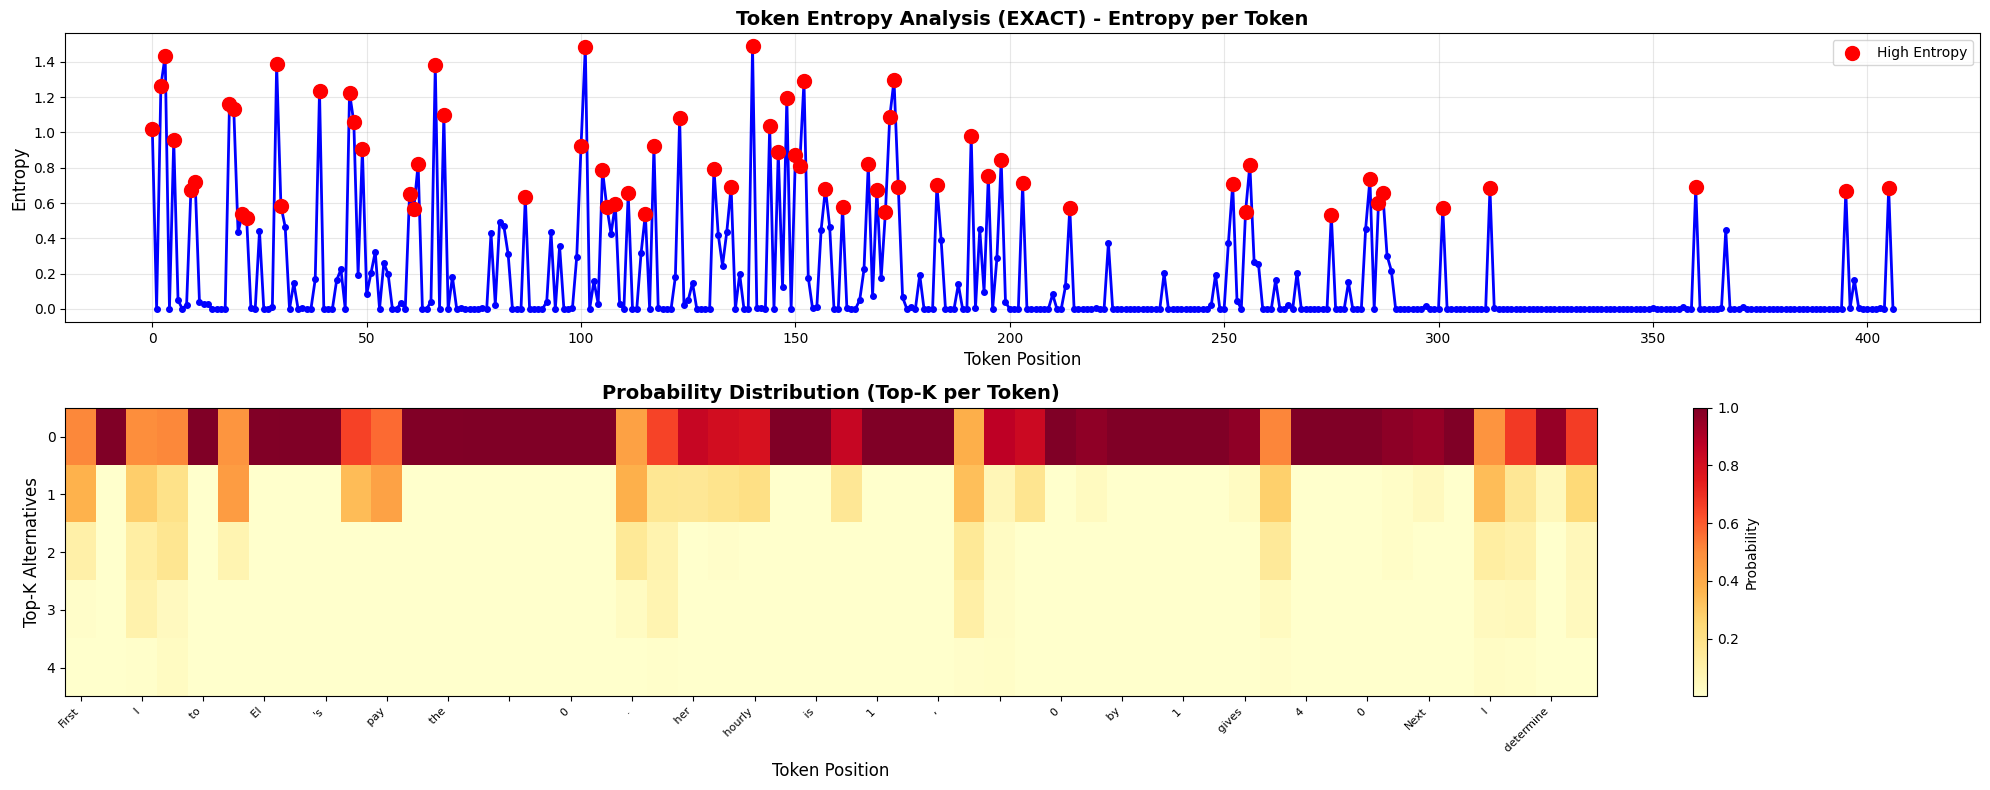

In [ ]:
scores = torch.stack(outputs.scores, dim=0)  # (T, B, V)

entropies = calculate_token_entropy_transformers(
    scores=scores,
    tokenizer=tokenizer,
    output_tokens=output_tokens,
    top_k_display=5
)

print(f"✓ Calculated entropy for {len(entropies)} tokens")
print(f"Probability coverage: {entropies[0]['prob_coverage']:.4f} (exact)")
print(f"Vocab size used: {entropies[0]['num_tokens_used']}")

# Visualize entropy
fig = visualize_entropy(entropies, title="Token Entropy Analysis (EXACT)")
plt.show()

In [ ]:
## 🛠️ Helper Function: Visualize by Output Position

def visualize_attention_at_output_token(
    attention_weights,
    output_token_index,  # Position in OUTPUT (0-indexed, no input)
    input_length,        # Length of input sequence
    layer_indices=[0, 14, 27],
    window_size=60,
    **kwargs
):
    """
    Convenience function to visualize attention at OUTPUT token position.
    Automatically converts output position to full position.
    """
    # Convert output position → full position
    full_token_index = output_token_index + input_length
    
    print(f"🎯 Converting positions:")
    print(f"   Output position: {output_token_index}")
    print(f"   + Input length: {input_length}")
    print(f"   = Full position: {full_token_index}\n")
    
    return visualize_attention_layers(
        attention_weights,
        layer_indices,
        token_index=full_token_index,
        window_size=window_size,
        **kwargs
    )

# Example usage (uncomment when ready):
# fig = visualize_attention_at_output_token(
#     attention_weights=forward_outputs.attentions,
#     output_token_index=50,  # ← Use output position directly!
#     input_length=input_length,
#     layer_indices=[0, 14, 27],
#     window_size=60
# )
# plt.show()


/tmp/ipykernel_27/1394277507.py:329: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


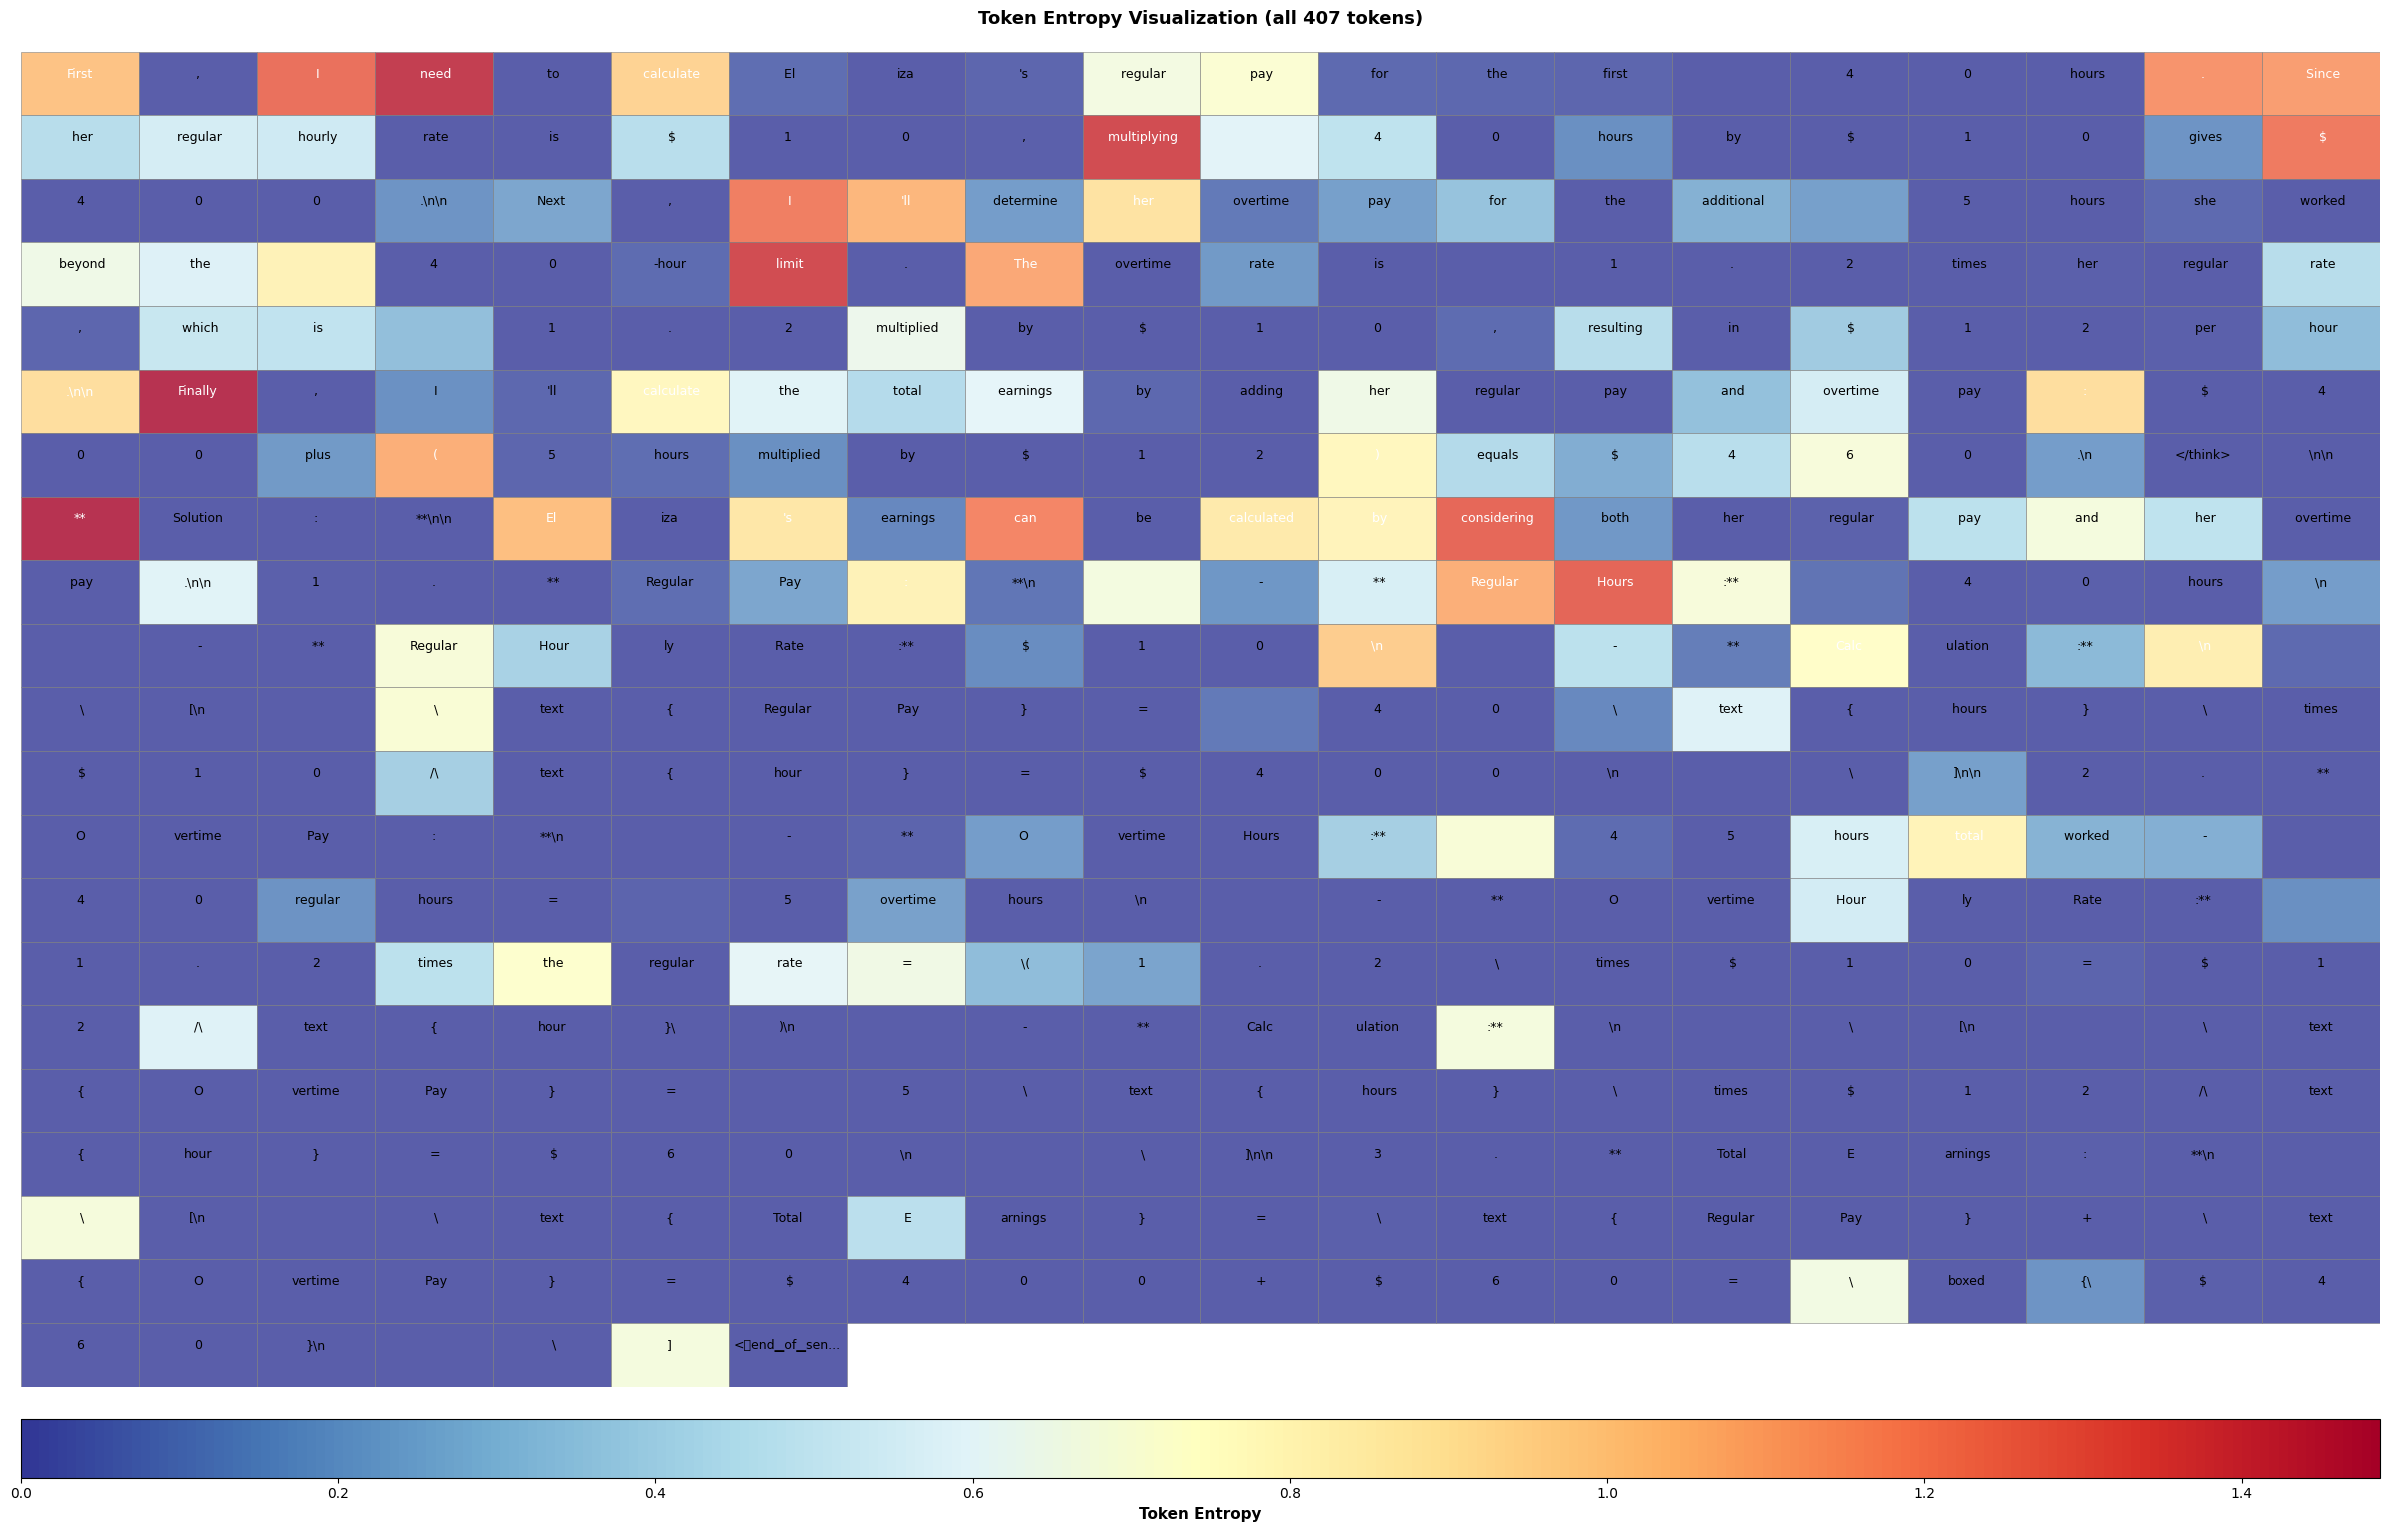

In [19]:
# Visualize all tokens
fig = visualize_tokens_with_entropy(
    entropies,
    start_idx=0,
    end_idx=None,  # None = hiển thị hết
    tokens_per_row=20,  # 20 tokens per row để fit screen
    show_entropy_values=False  # Set True nếu muốn hiển thị giá trị entropy
)
plt.show()


## Example 2: Attention Visualization (dùng output từ Example 1)


In [55]:
TOP_K = 10000  # ← Change this to get more/fewer tokens
range_idx = min(TOP_K, len(entropies))
entropy_values = np.array([e['entropy'] for e in entropies])
top_k_indices = np.argsort(entropy_values)[-range_idx:][::-1]  # Descending order

high_entropy_results = []
for rank, idx in enumerate(top_k_indices, 1):
    e = entropies[idx]
    output_pos = e['position']  # Position in OUTPUT (0-indexed, no input)
    full_pos = output_pos + input_length  # Position in FULL sequence (with input)
    
    high_entropy_results.append({
        'rank': rank,
        'output_position': output_pos,
        'full_position': full_pos,
        'token': e['token'],
        'entropy': e['entropy'],
        'top_alternatives': e['top_alternatives'][:3]  # Top 3 alternatives
    })

high_entropy_output_positions = [r['output_position'] for r in high_entropy_results]
high_entropy_full_positions = [r['full_position'] for r in high_entropy_results]

In [56]:
# Forward pass để lấy attentions
# Lấy full sequence (input + generated từ Example 1)
full_sequence = outputs.sequences  # Shape: (batch_size, total_seq_len)

print(f"Full sequence length: {full_sequence.shape[1]} tokens")

# Forward pass với full sequence để lấy attentions
print("Running forward pass to get attentions...")
with torch.no_grad():
    model.config._attn_implementation = "eager"
    model.config.output_attentions = True
    forward_outputs = model(
        input_ids=full_sequence,
        output_attentions=True,
        return_dict=True
    )

print(f"✓ Forward pass complete")
print(f"Attentions:")
print(f"  - Number of layers: {len(forward_outputs.attentions)}")
print(f"  - Layer 0 attention shape: {forward_outputs.attentions[0].shape}")
print(f"  - Format: (batch_size, num_heads, seq_len, seq_len)")


Full sequence length: 473 tokens
Running forward pass to get attentions...
✓ Forward pass complete
Attentions:
  - Number of layers: 28
  - Layer 0 attention shape: torch.Size([1, 28, 473, 473])
  - Format: (batch_size, num_heads, seq_len, seq_len)


In [57]:
attentions_to_use = forward_outputs.attentions

# Decode tokens cho labeling
generated_ids = outputs.sequences[0]
generated_tokens = [tokenizer.decode([tok]) for tok in generated_ids]

print(f"Total tokens in sequence: {len(generated_tokens)}")
print(f"Attentions available for {len(attentions_to_use)} layers")


Total tokens in sequence: 473
Attentions available for 28 layers


In [58]:
# Setup layers và heads để visualize
num_layers = model.config.num_hidden_layers
num_heads = model.config.num_attention_heads

print(f"Model has {num_layers} layers and {num_heads} attention heads per layer")

# Chọn layers và heads quan trọng để visualize
layers_heads = [
    (0, 0),                              # First layer, first head
    (num_layers // 2, 0),                # Middle layer, first head
    (num_layers // 2, num_heads // 2),   # Middle layer, middle head
    (num_layers - 1, 0),                 # Last layer, first head
    (num_layers - 1, num_heads // 2),    # Last layer, middle head
    (num_layers - 1, num_heads - 1),     # Last layer, last head
]

print(f"Will visualize layers/heads: {layers_heads}")


Model has 28 layers and 28 attention heads per layer
Will visualize layers/heads: [(0, 0), (14, 0), (14, 14), (27, 0), (27, 14), (27, 27)]


In [47]:
# Visualize attention heatmaps
# fig = visualize_attention(
#     attentions_to_use,
#     layers_heads=layers_heads,
#     tokens=generated_tokens,
#     max_tokens_display=20,
#     figsize_per_plot=(8, 6)
# )
# plt.show()


In [44]:
# Visualize mean attention patterns

# fig = visualize_attention_patterns(
#     attentions_to_use,
#     layers_heads=[(0, 0), (num_layers // 2, 0), (num_layers - 1, 0)],
#     tokens=generated_tokens,
#     pattern_type='mean',
#     figsize=(18, 5)
# )
# plt.show()

Visualizing layers: [0, 1, 2, 9, 14, 18, 27]


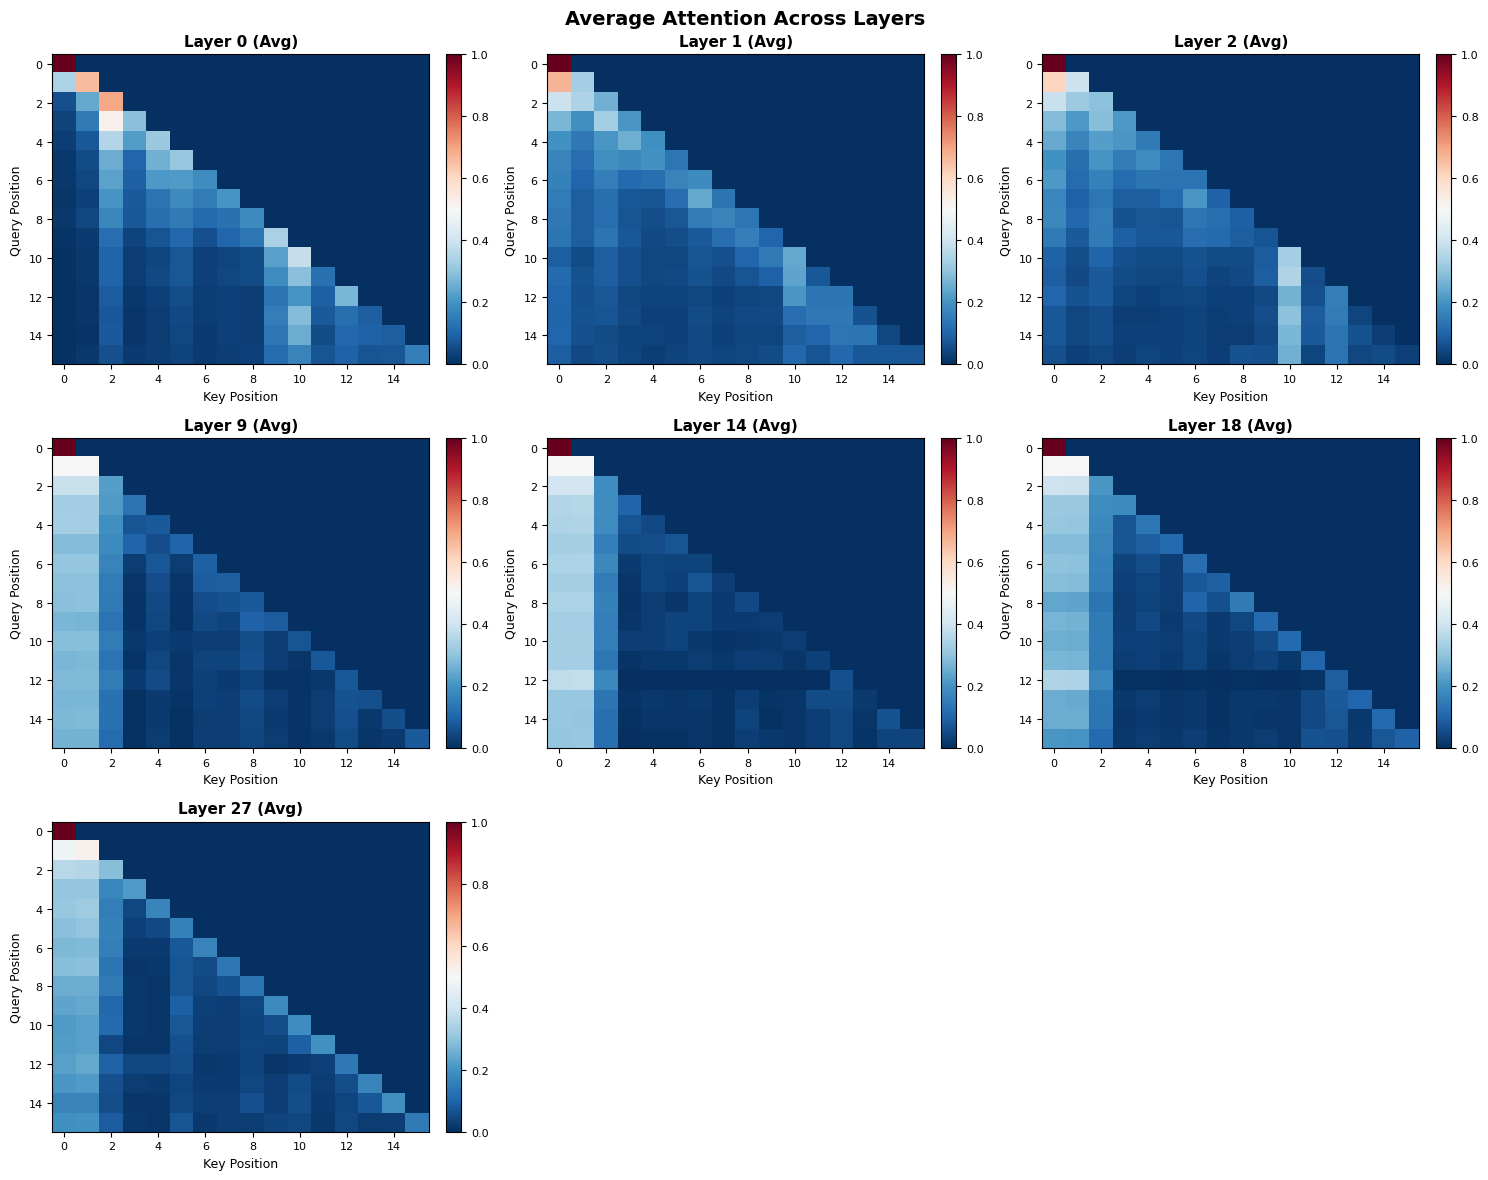

In [45]:
# Visualize attention cho nhiều layers

# Chọn các layers quan trọng để visualize
selected_layers = [0, 1, 2, num_layers // 3, num_layers // 2, 2*num_layers // 3, num_layers - 1]
print(f"Visualizing layers: {selected_layers}")

# Option 1: Average attention across all heads
fig = visualize_attention_layers(
    attentions_to_use,
    layer_indices=selected_layers,
    head_idx=None,  # None = average across all heads
    max_tokens_display=16,  # Giống như trong hình (16 tokens)
    cmap='RdBu_r',  # Red = high attention, Blue = low attention
    title='Average Attention Across Layers'
)
plt.show()


In [111]:
# Option 2: Visualize specific head (head 0) across layers
# fig = visualize_attention_layers(
#     attentions_to_use,
#     layer_indices=selected_layers,
#     head_idx=0,  # Specific head
#     max_tokens_display=20,
#     cmap='RdBu_r',
#     title=f'Attention Head 0 Across Layers'
# )
# plt.show()


Token: 'O' (idx=306), entropy=0.0001220703125
📍 Windowing around token 306:
   Full sequence length: 473
   Window: [296, 317) (size=21)
   Token position in window: 10


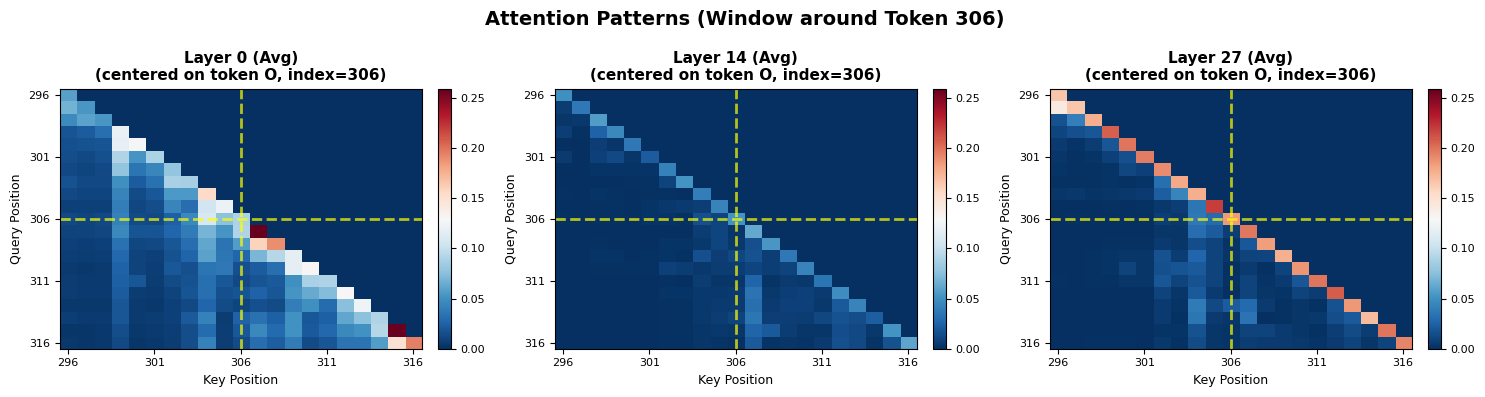

In [89]:
rank = 251
token_idx = high_entropy_results[min(rank, len(high_entropy_results)-1)]['full_position']
print(f"Token: '{high_entropy_results[min(rank, len(high_entropy_results)-1)]['token']}' (idx={token_idx}), entropy={high_entropy_results[min(rank, len(high_entropy_results)-1)]['entropy']}")
fig = visualize_attention_layers(
    attentions_to_use,
    layer_indices=[0, 14, 27],
    token_index=token_idx,  # ← center token
    window_size=20,     # ← Window size (±30 tokens),
    token = high_entropy_results[min(rank, len(high_entropy_results)-1)]['token'],
)

Token: '**' (idx=206), entropy=1.487192153930664
📍 Windowing around token 206:
   Full sequence length: 473
   Window: [181, 232) (size=51)
   Token position in window: 25


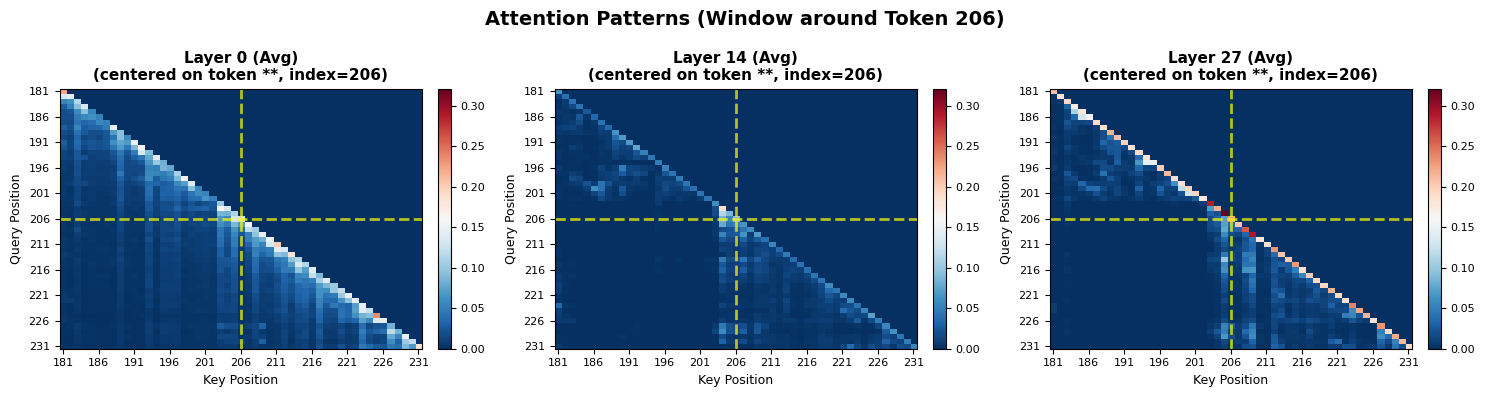

Token: 'Finally' (idx=167), entropy=1.4851207733154297
📍 Windowing around token 167:
   Full sequence length: 473
   Window: [142, 193) (size=51)
   Token position in window: 25


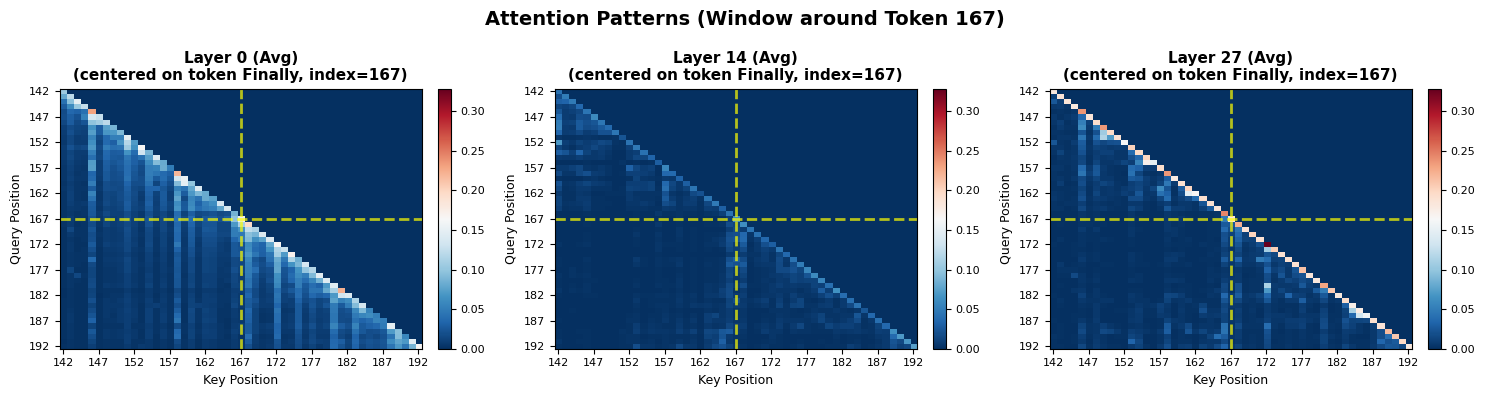

Token: ' need' (idx=69), entropy=1.4353218078613281
📍 Windowing around token 69:
   Full sequence length: 473
   Window: [44, 95) (size=51)
   Token position in window: 25


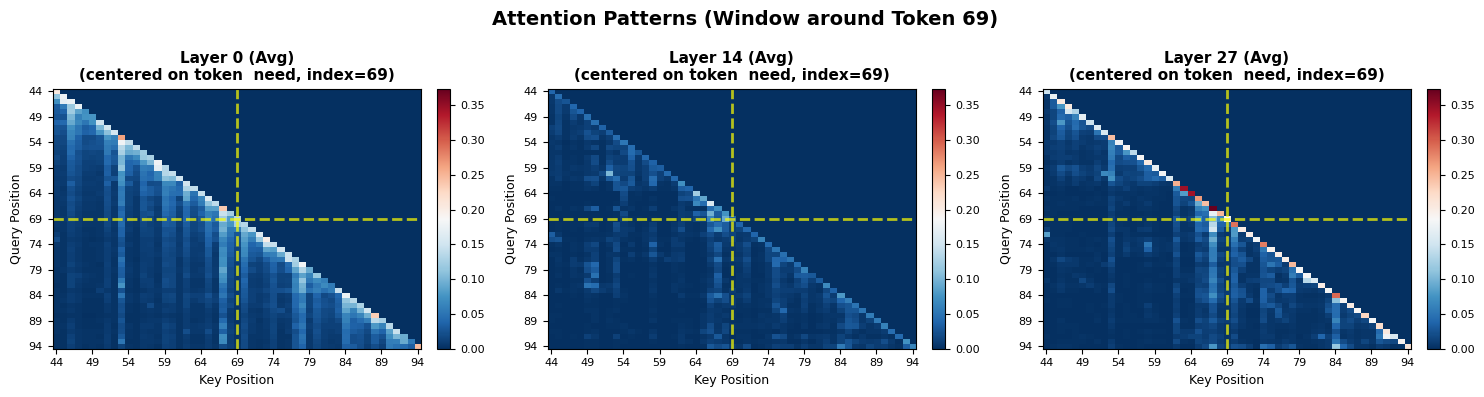

Token: ' multiplying' (idx=95), entropy=1.3863849639892578
📍 Windowing around token 95:
   Full sequence length: 473
   Window: [70, 121) (size=51)
   Token position in window: 25


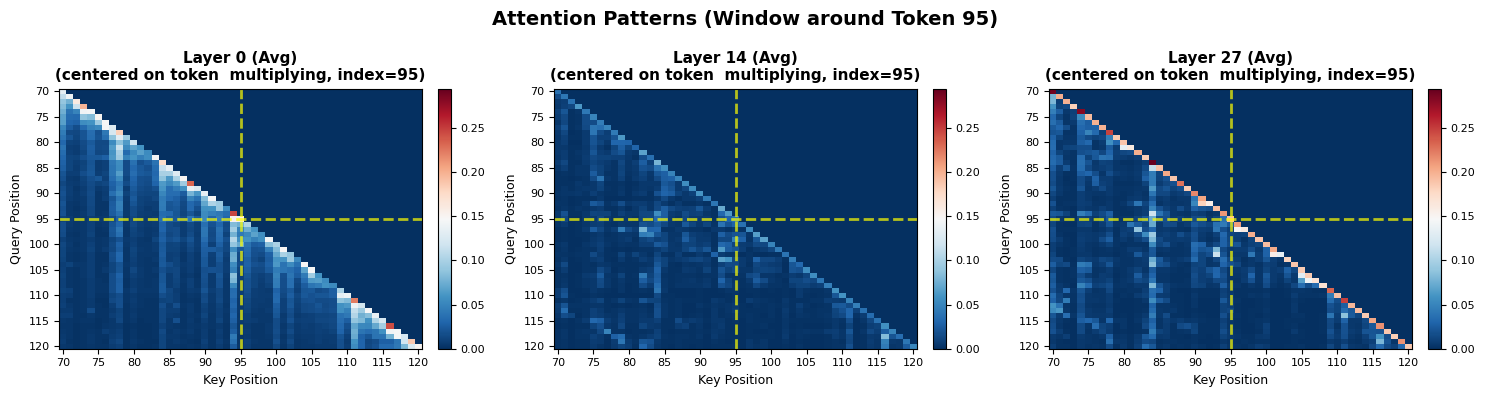

Token: ' limit' (idx=132), entropy=1.384124755859375
📍 Windowing around token 132:
   Full sequence length: 473
   Window: [107, 158) (size=51)
   Token position in window: 25


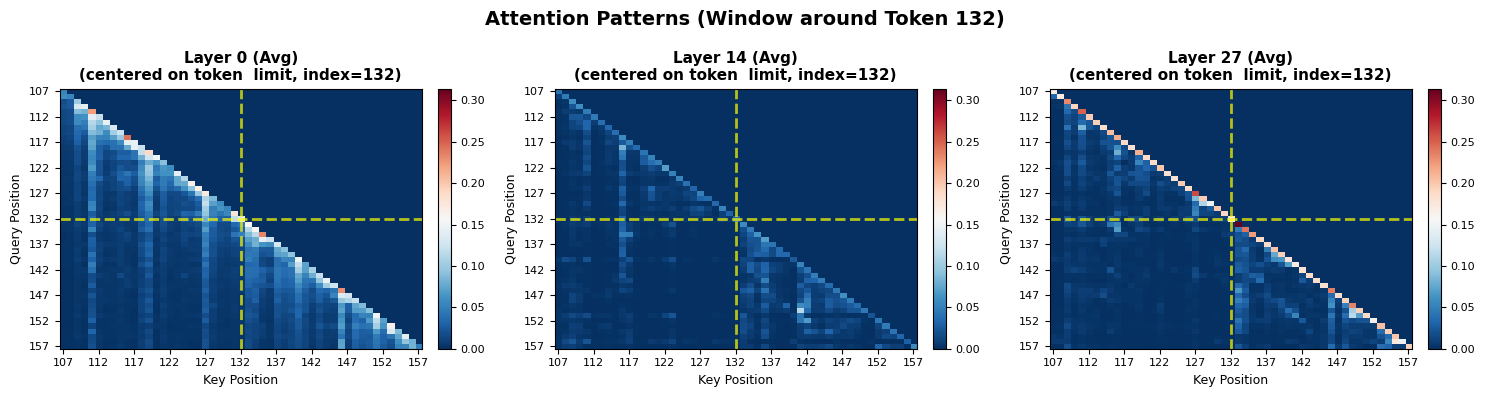

In [113]:
for rank in range(0, 5):
    token_idx = high_entropy_results[min(rank, len(high_entropy_results)-1)]['full_position']
    print(f"Token: '{high_entropy_results[min(rank, len(high_entropy_results)-1)]['token']}' (idx={token_idx}), entropy={high_entropy_results[min(rank, len(high_entropy_results)-1)]['entropy']}")
    fig = visualize_attention_layers(
        attentions_to_use,
        window_size=50,
        layer_indices=[0, 14, 27],
        token_index=token_idx,  # ← center token
        token = high_entropy_results[min(rank, len(high_entropy_results)-1)]['token'],
    )
    plt.show()

Token: '}\' (idx=371), entropy=0.000431060791015625
📍 Windowing around token 371:
   Full sequence length: 473
   Window: [346, 397) (size=51)
   Token position in window: 25


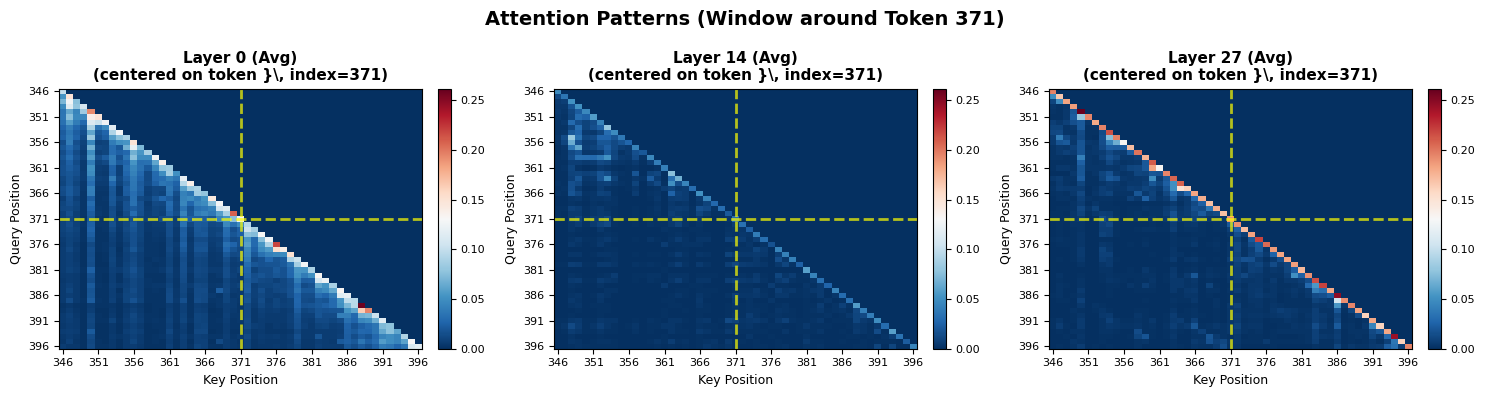

Token: ' ' (idx=80), entropy=0.000431060791015625
📍 Windowing around token 80:
   Full sequence length: 473
   Window: [55, 106) (size=51)
   Token position in window: 25


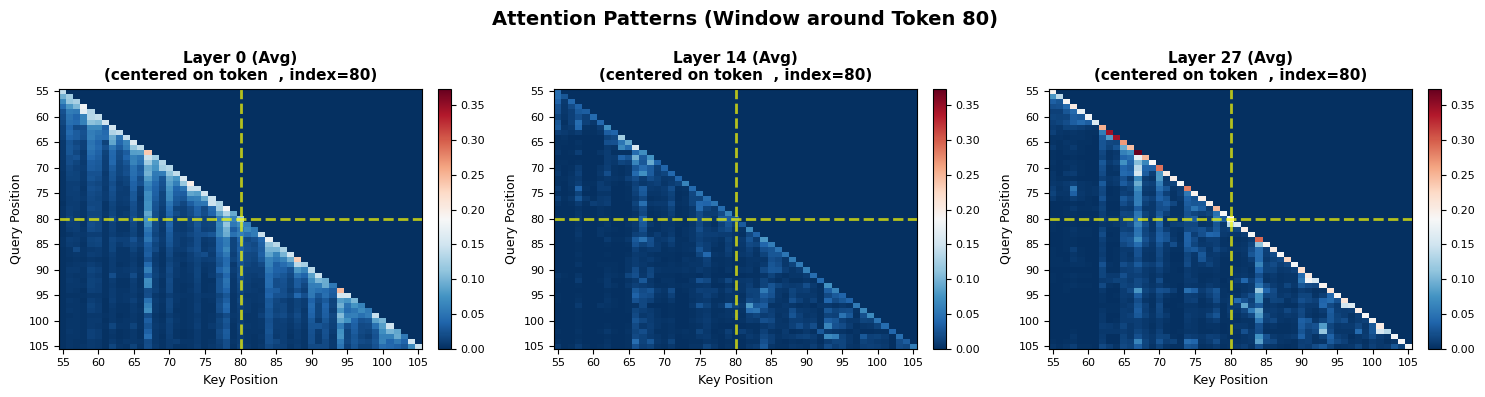

Token: ' \$' (idx=364), entropy=0.000423431396484375
📍 Windowing around token 364:
   Full sequence length: 473
   Window: [339, 390) (size=51)
   Token position in window: 25


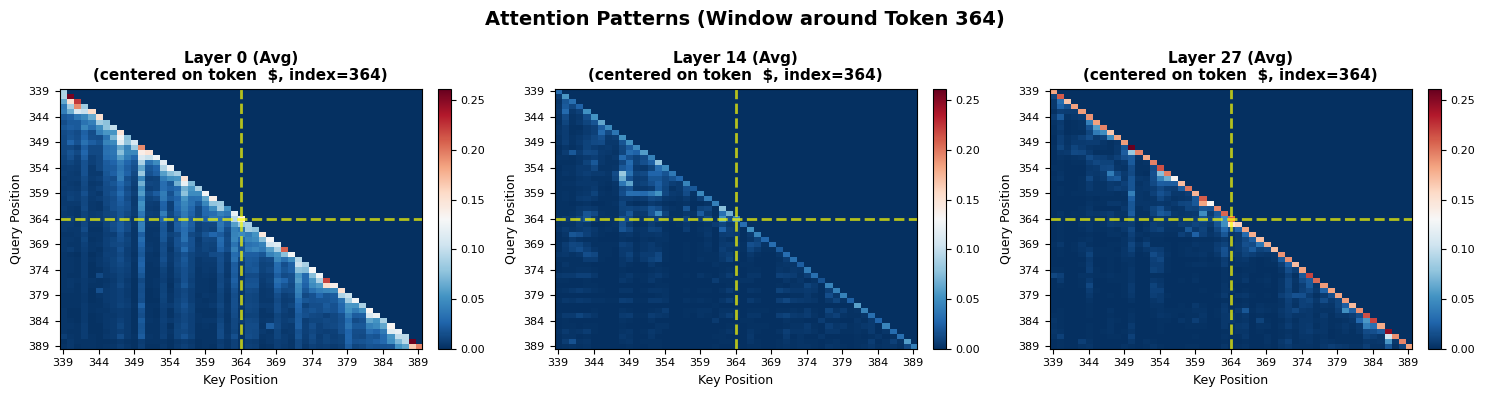

Token: ' regular' (idx=144), entropy=0.000408172607421875
📍 Windowing around token 144:
   Full sequence length: 473
   Window: [119, 170) (size=51)
   Token position in window: 25


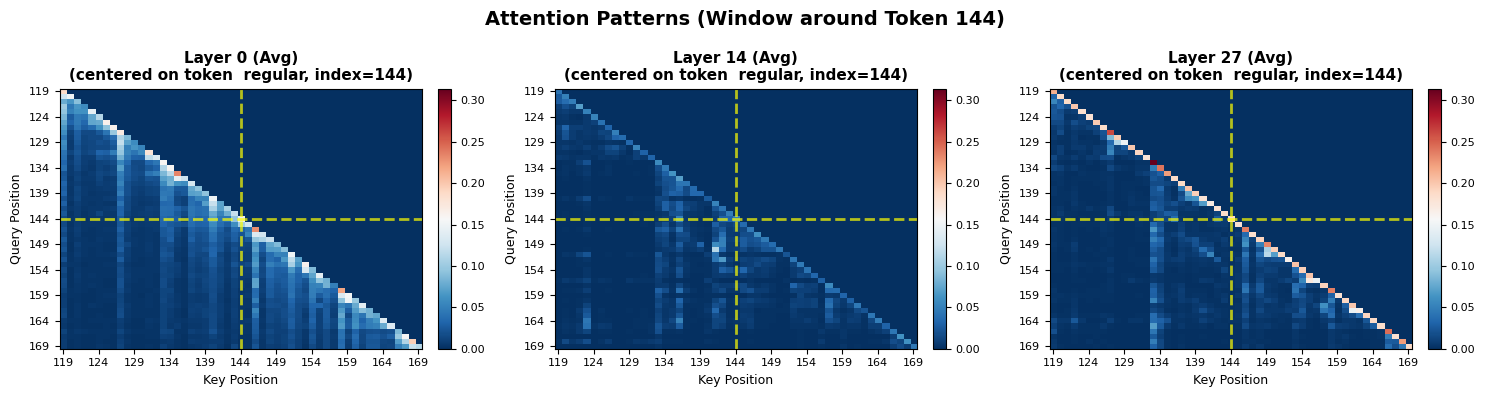

Token: ' the' (idx=119), entropy=0.0004024505615234375
📍 Windowing around token 119:
   Full sequence length: 473
   Window: [94, 145) (size=51)
   Token position in window: 25


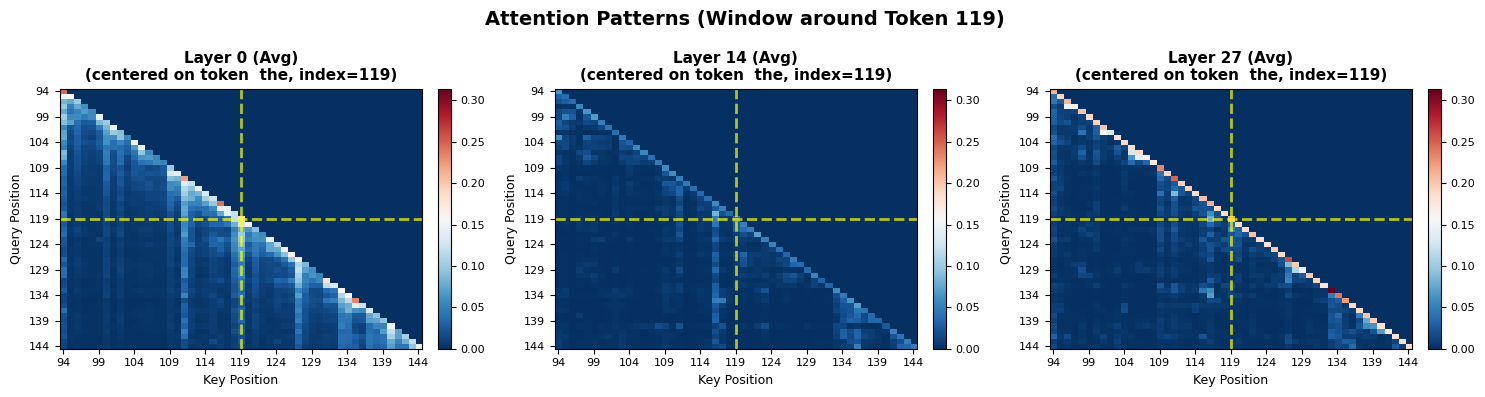

In [114]:
for rank in range(200, 205):
    token_idx = high_entropy_results[min(rank, len(high_entropy_results)-1)]['full_position']
    print(f"Token: '{high_entropy_results[min(rank, len(high_entropy_results)-1)]['token']}' (idx={token_idx}), entropy={high_entropy_results[min(rank, len(high_entropy_results)-1)]['entropy']}")
    fig = visualize_attention_layers(
        attentions_to_use,
        window_size=50,
        layer_indices=[0, 14, 27],
        token_index=token_idx,  # ← center token
        token = high_entropy_results[min(rank, len(high_entropy_results)-1)]['token'],
    )
    plt.show()


## Analyze Attention Around High Entropy Tokens

📊 Visualization settings:
   Input length: 66
   Total tokens: 473
   Output tokens: 407

Found 1 high entropy tokens (in OUTPUT)
Input length: 66, Total tokens: 473

1. Output pos  140 (Full pos  206): '**' (Entropy: 1.4872)


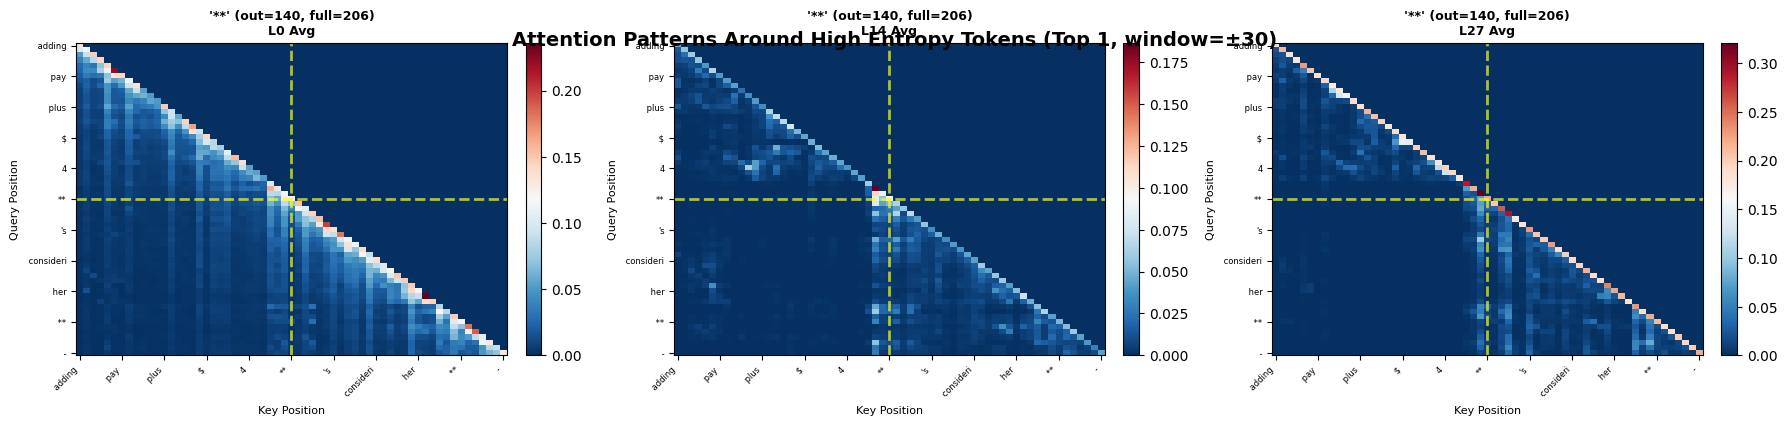

In [108]:
# Get input length for position offset
input_length = inputs.input_ids.shape[1]

print(f"📊 Visualization settings:")
print(f"   Input length: {input_length}")
print(f"   Total tokens: {len(generated_tokens)}")
print(f"   Output tokens: {len(entropies)}")

# Option 1: Analyze top 5 highest entropy tokens
high_entropy_tokens, fig = visualize_attention_around_high_entropy(
    attention_weights=attentions_to_use,
    entropies=entropies,
    tokens=generated_tokens,
    input_length=input_length,  # ← CRITICAL for position offset
    threshold_method='top_k',
    k=1,  # Top 5 tokens
    layer_indices=[0, 14, 27],  # First, middle, last layers
    head_idx=None,  # Average all heads
    context_window=30,  # Show ±50 tokens (100 total) - INCREASED!
    figsize=None  # Auto
)
plt.show()


#### bar chart attention

/tmp/ipykernel_27/3592827394.py:294: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


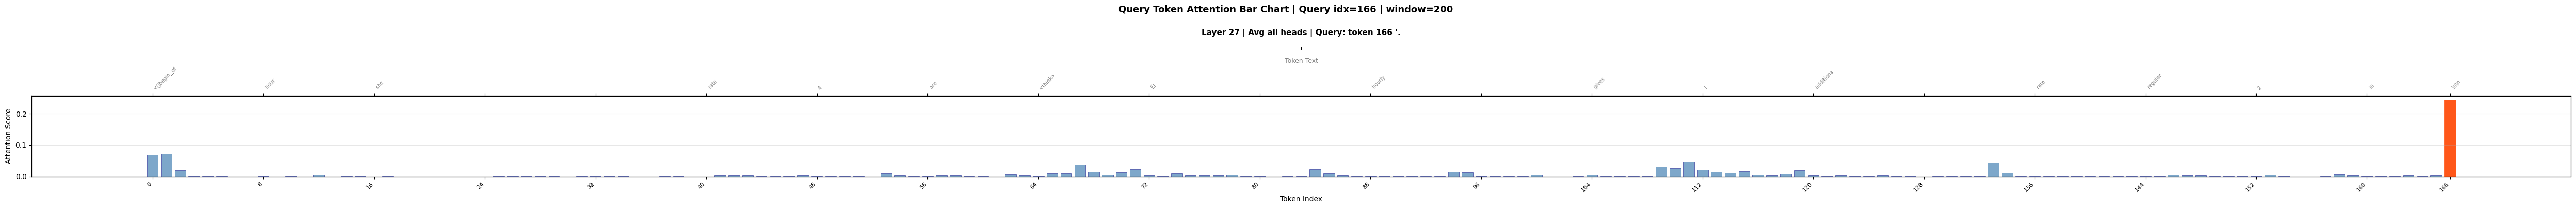

In [119]:
query_idx = 166

fig = visualize_query_attention_barchart(
    attention_weights=attentions_to_use,
    tokens=generated_tokens,
    query_token_idx=query_idx,
    window_size=200,
    layer_idx=[27],  # First, middle, last layers
    mode='average'
)
plt.show()